# Pedro Ribeiro

O desafio é **desenvolver uma solução para agrupar clientes baseado nos seus perfis de gastos**.
Para atingir esse objetivo, serão executados os seguintes passos:

1. Realizar uma análise exploratória profunda dos dados para entender as características e padrões de gastos dos clientes.
2. Criar uma nova feature que identifique se as transações se referem a gastos fixos ou variáveis.
3. Utilizar técnicas de clustering para segmentar os clientes em diferentes perfis de gastos.
4. Com base na análise exploratória, etiquetar cada cluster identificado com padrões de gastos quanto à quantidade, natureza (fixo/variado) e categoria da compra (como alimentação, saúde, lazer, etc.).
5. Responder às seguintes perguntas:
   - Quais os perfis de clientes que mais gastam proporcionalmente em gastos fixos?
   - Quais as categorias de compra que mais impactam nos perfis de gasto?
   - Quais são os perfis centrais (ou típicos) de cada cluster?

# Libraries

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re
from dotenv import load_dotenv
from matplotlib.colors import ListedColormap

from sklearn.neighbors import KNeighborsClassifier  # for classification
# OR
# from sklearn.neighbors import KNeighborsRegressor  # for regression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Dataframes

In [2]:
load_dotenv(".env")
path_dir = os.environ.get('path_dir')

In [3]:
os.chdir(path_dir)

In [4]:
accounts = pd.read_csv(os.getcwd()+'/data/accounts.csv')
display(accounts.head())
person = pd.read_csv(os.getcwd()+'/data/person.csv')
display(person.head())
transactions = pd.read_csv(os.getcwd()+'/data/transactions.csv')
display(transactions.head())

,id,type,subtype,balance,currency_code,name,person_id,account_id,date
0,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,BRL,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-09-14 14:03:16
1,978f92cf-8d5b-437a-a046-cdaa9105624c,CREDIT,CREDIT_CARD,6311.67,BRL,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,978f92cf-8d5b-437a-a046-cdaa9105624c,2023-09-15 15:50:21
2,dcd96f70-8b16-42b0-a944-afec5d8305ce,CREDIT,CREDIT_CARD,7482.25,BRL,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,dcd96f70-8b16-42b0-a944-afec5d8305ce,2023-09-09 03:38:49
3,6c2a44fe-2ba7-4626-aaff-f244a0647eae,BANK,SAVINGS_ACCOUNT,5740.29,BRL,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,6c2a44fe-2ba7-4626-aaff-f244a0647eae,2023-09-12 14:21:21
4,abb359a2-3802-48e7-976b-8671e1de0884,BANK,CHECKING_ACCOUNT,5136.49,BRL,Conta Corrente,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,abb359a2-3802-48e7-976b-8671e1de0884,2023-09-12 04:10:04


,id,name,suitability
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador
1,01018c18-ecb5-4cb6-b16f-bece97935974,Emilly Moura,moderado-agressivo
2,65d3336e-dafd-4663-8a53-97792c847074,Luiz Miguel Caldeira,conservador
3,6a33c027-13f2-4fbf-8bbb-74e6438d11c8,Sarah Souza,moderado-conservador
4,55252085-c5d6-4b7d-b221-fd3ad76ba8e5,Samuel Oliveira,moderado-agressivo


,id,currency_code,amount,date,category,account_id
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,BRL,-498.71,2023-07-20 03:57:57,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b
1,b8d83679-02ab-4241-b15d-11e9c0033864,BRL,-265.00,2023-07-23 05:17:06,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b
2,99cab263-da5c-4706-9f2c-92cb779acaf7,BRL,-18.95,2023-06-26 05:54:25,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b
3,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,BRL,-262.70,2023-06-21 00:34:08,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b
4,fc4e9552-bb41-4757-8c16-ff2c584ee01b,BRL,-179.44,2023-08-05 01:09:42,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b


In [5]:
print('Saída', transactions[transactions.amount < 0].category.unique())
print('Entrada', transactions[transactions.amount > 0].category.unique())
print('Zero', transactions[transactions.amount == 0].category.unique())

Saída ['Educação' 'Outras saídas' 'Transporte' 'Imposto, juros e multa'
 'Alimentação' nan 'Saúde' 'Moradia' 'Compras' 'Lazer']
Entrada ['Investimento' 'Recebido']
Zero []


In [6]:
are_columns_equal = accounts['id'].equals(accounts['account_id'])
are_columns_equal

True

In [7]:
print(accounts.currency_code.unique())
print(transactions.currency_code.unique())

['BRL']
['BRL']


In [8]:
# Retirar colunas 'currency_code', pois só possui o valor 'BRL'
# Retirar colunas 'account_id', pois os valores são iguais a da coluna 'id'
accounts.drop('currency_code', axis='columns', inplace=True)
accounts.drop('account_id', axis='columns', inplace=True)
transactions.drop('currency_code', axis='columns', inplace=True)

In [9]:
accounts['date_acc'] = pd.to_datetime(accounts['date']).map(lambda x:x.date())
accounts.drop('date', axis='columns', inplace=True)
transactions['date_trans'] = pd.to_datetime(transactions['date']).map(lambda x:x.date())
transactions.drop('date', axis='columns', inplace=True)

In [10]:
transactions_null = transactions[transactions.category.isnull()]
transactions_null[transactions_null.amount>0]

,id,amount,category,account_id,date_trans


In [11]:
# tranformação de todos os gastos em valores positivos pois a coluna 'category', já ndica que os valores são negaticos
transactions['amount'] = transactions['amount'].map(lambda x:abs(x))

In [12]:
def has_non_letter(string):
    pattern = r'[^a-zA-Záàâãéèêíïóôõöúçñ\s]'
    return bool(re.search(pattern, string))

strings = person.name

for string in strings:
    if has_non_letter(string):
        print(f"{string}")
    pass

Dr. Gustavo Henrique Viana
Sr. Erick Rezende
Dr. Lucca Moraes
Srta. Rebeca da Rocha
Srta. Maria Fernanda Castro
Sr. Otávio Porto
Srta. Sophia Pereira
Dra. Rafaela Barros
Dra. Sarah Freitas
Srta. Lívia Pinto
Dra. Laís Rezende
Sra. Gabriela Nunes
Sr. Pedro Henrique Duarte
Srta. Camila Farias
Dr. Marcelo Dias
Sra. Sophia Viana
Dra. Ana Julia das Neves
Srta. Sofia Barbosa
Sra. Rebeca Pires
Dra. Beatriz Moura
Dra. Kamilly Martins
Dra. Gabrielly Novaes
Dr. Cauê Silva
Sr. Yago Costa
Srta. Caroline Almeida
Dra. Júlia Silveira
Sra. Maria Vitória Caldeira
Sra. Marcela Lima
Sra. Ana das Neves
Dra. Maria Cecília Oliveira
Sra. Alícia Oliveira
Srta. Eduarda Ferreira
Dra. Maria Cecília Ribeiro
Sra. Marina Ribeiro
Dr. Breno Freitas
Sr. João Pedro Duarte
Dra. Rebeca Moura
Srta. Maysa Jesus
Dr. Yuri Teixeira
Sr. Thomas da Cruz
Sra. Alana Freitas
Srta. Ana Beatriz da Rosa
Sra. Raquel Fogaça
Dr. Pietro Rodrigues
Dr. Noah Rocha
Dr. Renan Barbosa
Sra. Pietra da Conceição
Dr. João Felipe Freitas
Dr. Henrique

In [13]:
# Retirando os pronomes dos nome dos clientes no intúito de limpar os dados  
person['person_name'] = person['name'].apply(lambda x: x.split(". ")[1] if x.startswith("Dr. ") or x.startswith("Dra. ") or x.startswith("Sr. ") or x.startswith("Sra. ") or x.startswith("Srta. ") else x)

In [14]:
strings = person.person_name

for string in strings:
    if has_non_letter(string):
        print(f"{string}")
    pass

In [15]:
display(accounts.head())
display(person.head())
display(transactions.head())

,id,type,subtype,balance,name,person_id,date_acc
0,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14
1,978f92cf-8d5b-437a-a046-cdaa9105624c,CREDIT,CREDIT_CARD,6311.67,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-15
2,dcd96f70-8b16-42b0-a944-afec5d8305ce,CREDIT,CREDIT_CARD,7482.25,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-09
3,6c2a44fe-2ba7-4626-aaff-f244a0647eae,BANK,SAVINGS_ACCOUNT,5740.29,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-12
4,abb359a2-3802-48e7-976b-8671e1de0884,BANK,CHECKING_ACCOUNT,5136.49,Conta Corrente,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-12


,id,name,suitability,person_name
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos
1,01018c18-ecb5-4cb6-b16f-bece97935974,Emilly Moura,moderado-agressivo,Emilly Moura
2,65d3336e-dafd-4663-8a53-97792c847074,Luiz Miguel Caldeira,conservador,Luiz Miguel Caldeira
3,6a33c027-13f2-4fbf-8bbb-74e6438d11c8,Sarah Souza,moderado-conservador,Sarah Souza
4,55252085-c5d6-4b7d-b221-fd3ad76ba8e5,Samuel Oliveira,moderado-agressivo,Samuel Oliveira


,id,amount,category,account_id,date_trans
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,498.71,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-20
1,b8d83679-02ab-4241-b15d-11e9c0033864,265.00,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-23
2,99cab263-da5c-4706-9f2c-92cb779acaf7,18.95,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-26
3,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,262.70,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-21
4,fc4e9552-bb41-4757-8c16-ff2c584ee01b,179.44,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-08-05


# Exploratory analysis

### 1. Análise Exploratória de Dados - Univariada

Primeiramente irei realizar uma análise exploratóiria para cada variável de cada um dos datasets separadamente para entender o comportamento geral e verificar valores faltantes

### Person

In [16]:
person.shape

(2531, 4)

In [17]:
display(person.head())
display(person.tail())

,id,name,suitability,person_name
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Ana Julia Santos,conservador,Ana Julia Santos
1,01018c18-ecb5-4cb6-b16f-bece97935974,Emilly Moura,moderado-agressivo,Emilly Moura
2,65d3336e-dafd-4663-8a53-97792c847074,Luiz Miguel Caldeira,conservador,Luiz Miguel Caldeira
3,6a33c027-13f2-4fbf-8bbb-74e6438d11c8,Sarah Souza,moderado-conservador,Sarah Souza
4,55252085-c5d6-4b7d-b221-fd3ad76ba8e5,Samuel Oliveira,moderado-agressivo,Samuel Oliveira


,id,name,suitability,person_name
2526,39f66a6b-1a60-4ee5-b186-3c0e7400004b,Kevin da Conceição,conservador,Kevin da Conceição
2527,5050325b-5bcd-40a3-a6ac-5f14ada7dc5b,Lara da Mota,agressivo,Lara da Mota
2528,480997ba-051c-46b1-90d1-c5e99686351d,Sr. Guilherme Peixoto,moderado,Guilherme Peixoto
2529,526c75ce-fcc9-405a-8e6a-15b6c9cde719,Enzo Nascimento,NaN,Enzo Nascimento
2530,fabc96ce-3723-42dc-8cbe-0aba93fcd773,Maria Clara Pereira,conservador,Maria Clara Pereira


In [18]:
person.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2531 entries, 0 to 2530
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           2531 non-null   object
 1   name         2531 non-null   object
 2   suitability  2084 non-null   object
 3   person_name  2531 non-null   object
dtypes: object(4)
memory usage: 79.2+ KB


In [19]:
person.duplicated().sum()

0

In [20]:
filtered_null_suitability = person[person['suitability'].isnull()]
filtered_null_suitability

,id,name,suitability,person_name
13,6af9c508-a57a-43cb-9ab3-2aecf18f5cea,Ana Beatriz Jesus,NaN,Ana Beatriz Jesus
14,cf0c52f9-5542-495d-b1f3-02b83366c861,Lavínia Farias,NaN,Lavínia Farias
16,3b273d75-dbc5-4b87-9cf0-1fe0587b349c,Luiz Otávio Azevedo,NaN,Luiz Otávio Azevedo
32,1ce95f5d-eaf8-464c-9809-e98eb44bebf2,Maria Julia Silva,NaN,Maria Julia Silva
34,d3f7da64-ef01-441f-9cbd-7c22534f586c,Srta. Rebeca da Rocha,NaN,Rebeca da Rocha
...,...,...,...,...
2505,197280f3-84a2-4167-bab4-bd7f7375abce,Luiz Felipe Rocha,NaN,Luiz Felipe Rocha
2507,069ea8f2-f744-4aeb-a320-fb576c50229b,Otávio Cunha,NaN,Otávio Cunha
2520,b50fa919-195d-479b-911d-efc9889ca4c1,Breno Lopes,NaN,Breno Lopes
2521,9717e592-5fcc-4f58-8b69-5602e79fc16f,André Peixoto,NaN,André Peixoto


In [21]:
print(f"The dataframe has {len(filtered_null_suitability)} missing values in the suitability of a total of {len(person)}: {round((len(filtered_null_suitability)/len(person)*100),1)}%")

The dataframe has 447 missing values in the suitability of a total of 2531: 17.7%


In [22]:
person['suitability'].fillna("no_suitability", inplace=True)

no_suitability          447
agressivo               444
conservador             422
moderado-agressivo      420
moderado                410
moderado-conservador    388
Name: suitability, dtype: int64

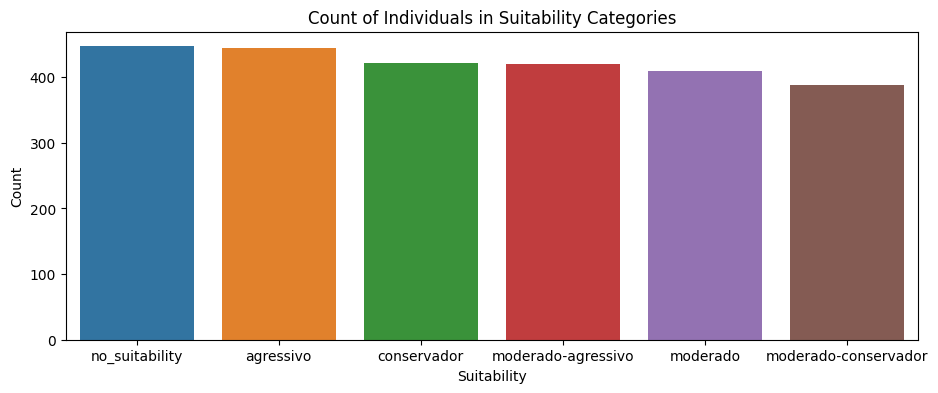

In [23]:
display(person["suitability"].value_counts())

plt.figure(figsize=(11, 4))
sns.barplot(y=person["suitability"].value_counts().values, 
            x=person["suitability"].value_counts().index)
plt.xlabel('Suitability')
plt.ylabel('Count')
plt.title('Count of Individuals in Suitability Categories')
plt.show()

agressivo               444
conservador             422
moderado-agressivo      420
moderado                410
moderado-conservador    388
Name: suitability, dtype: int64

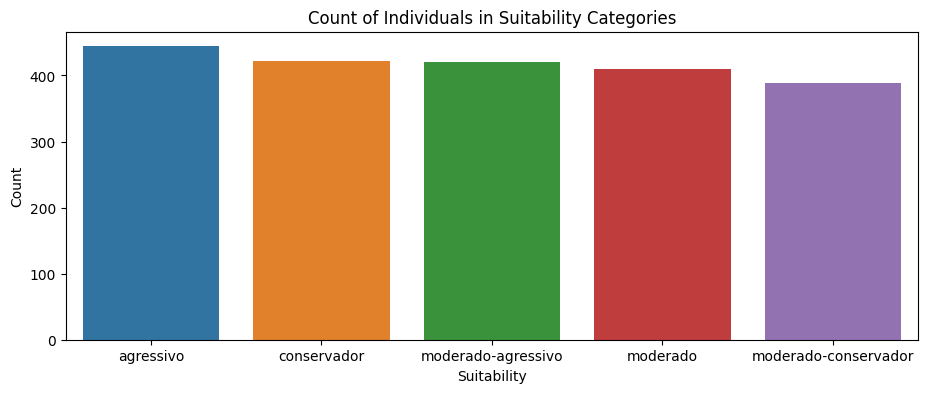

In [24]:
display(person[person["suitability"] != "no_suitability"]["suitability"].value_counts())

plt.figure(figsize=(11, 4))
sns.barplot(y=person[person["suitability"] != "no_suitability"]["suitability"].value_counts().values, 
            x=person[person["suitability"] != "no_suitability"]["suitability"].value_counts().index)
plt.xlabel('Suitability')
plt.ylabel('Count')
plt.title('Count of Individuals in Suitability Categories')
plt.show()

In [25]:
print("""
Constatado que possuem nomes repetitos no banco de dados. Caso precise utilizar o nome de cada cliente, o 
melhor será utilizar o id de identificação de cada cliente pois é único
""")
person.describe()


Constatado que possuem nomes repetitos no banco de dados. Caso precise utilizar o nome de cada cliente, o 
melhor será utilizar o id de identificação de cada cliente pois é único



,id,name,suitability,person_name
count,2531,2531,2531,2531
unique,2531,2374,6,2313
top,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,Felipe Peixoto,no_suitability,Ana Castro
freq,1,3,447,3


### Accounts

In [26]:
accounts.shape

(7569, 7)

In [27]:
display(accounts.head())
display(accounts.tail())

,id,type,subtype,balance,name,person_id,date_acc
0,1968bd13-dd25-4f88-bccc-5cff92d6811b,BANK,SAVINGS_ACCOUNT,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14
1,978f92cf-8d5b-437a-a046-cdaa9105624c,CREDIT,CREDIT_CARD,6311.67,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-15
2,dcd96f70-8b16-42b0-a944-afec5d8305ce,CREDIT,CREDIT_CARD,7482.25,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-09
3,6c2a44fe-2ba7-4626-aaff-f244a0647eae,BANK,SAVINGS_ACCOUNT,5740.29,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-12
4,abb359a2-3802-48e7-976b-8671e1de0884,BANK,CHECKING_ACCOUNT,5136.49,Conta Corrente,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-12


,id,type,subtype,balance,name,person_id,date_acc
7564,88f496c6-eac6-422f-8a4d-e88ca3fe0351,BANK,SAVINGS_ACCOUNT,12044.12,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-15
7565,e3ca889d-2b1c-464a-be4f-b7719822ba98,CREDIT,CREDIT_CARD,12351.60,Cartão de Crédito,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-14
7566,c64d8afc-409f-446e-a19c-a8c9c0c5e57b,CREDIT,CREDIT_CARD,9555.10,Cartão de Crédito,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-08-29
7567,8c709383-2d35-4796-995f-3eea8e7fefd9,CREDIT,CREDIT_CARD,5044.89,Cartão de Crédito,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-15
7568,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,BANK,SAVINGS_ACCOUNT,3788.95,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-15


In [28]:
accounts.info()
# Não possuem valores Null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7569 entries, 0 to 7568
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         7569 non-null   object 
 1   type       7569 non-null   object 
 2   subtype    7569 non-null   object 
 3   balance    7569 non-null   float64
 4   name       7569 non-null   object 
 5   person_id  7569 non-null   object 
 6   date_acc   7569 non-null   object 
dtypes: float64(1), object(6)
memory usage: 414.1+ KB


In [29]:
accounts.duplicated().sum()

0

In [30]:
accounts.columns

Index(['id', 'type', 'subtype', 'balance', 'name', 'person_id', 'date_acc'], dtype='object')

In [31]:
print("max", accounts.date_acc.max())
print("min", accounts.date_acc.min())

max 2023-09-15
min 2023-06-20


In [32]:
accounts['year_month_acc'] = accounts.date_acc.map(lambda x:str(x.year))+"/"+accounts.date_acc.map(lambda x:str(x.month))
display(accounts['year_month_acc'].value_counts())

2023/9    7199
2023/8     302
2023/7      58
2023/6      10
Name: year_month_acc, dtype: int64

9    7199
8     302
7      58
6      10
Name: date_acc, dtype: int64

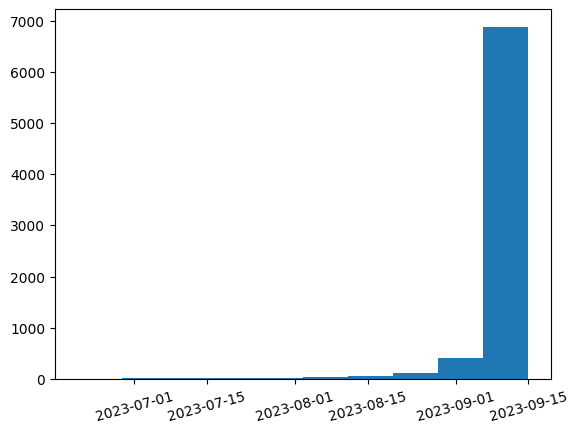

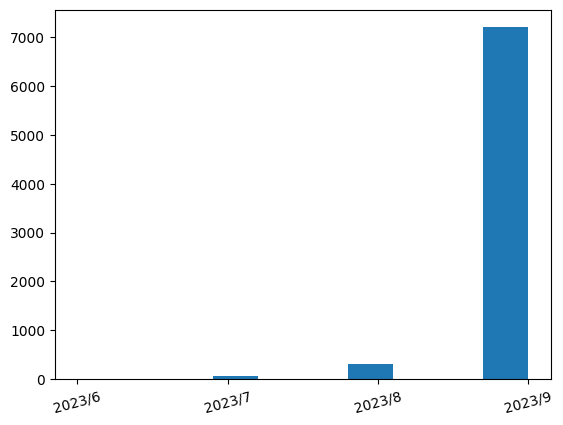

In [33]:
display(accounts.date_acc.map(lambda x:x.month).value_counts())

plt.hist(accounts.date_acc, bins=10)
plt.xticks(rotation=15)
plt.show()

plt.hist(accounts.year_month_acc.sort_values(), bins=10)
plt.xticks(rotation=15)
plt.show()

In [34]:
accounts.describe()

,balance
count,7569.000000
mean,5717.472539
std,4825.408916
min,11.520000
25%,2514.880000
50%,5021.490000
75%,7558.410000
max,44965.250000


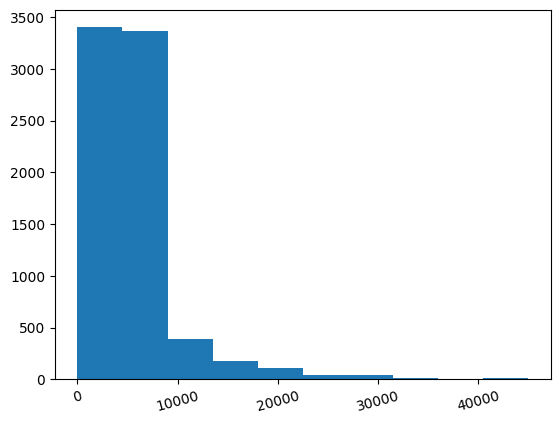

In [35]:
plt.hist(accounts.balance, bins=10)
plt.xticks(rotation=15)
plt.show()

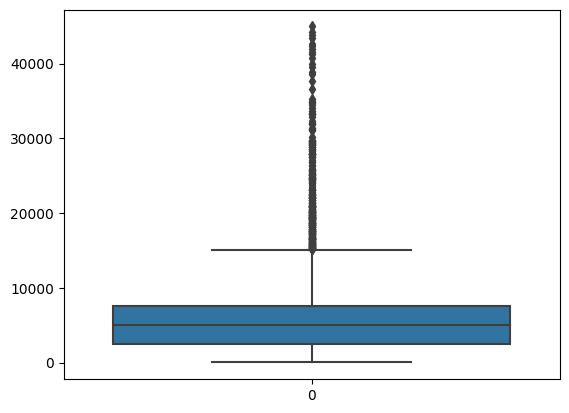

In [36]:
sns.boxplot(accounts.balance)
plt.show()

BANK      4950
CREDIT    2619
Name: type, dtype: int64

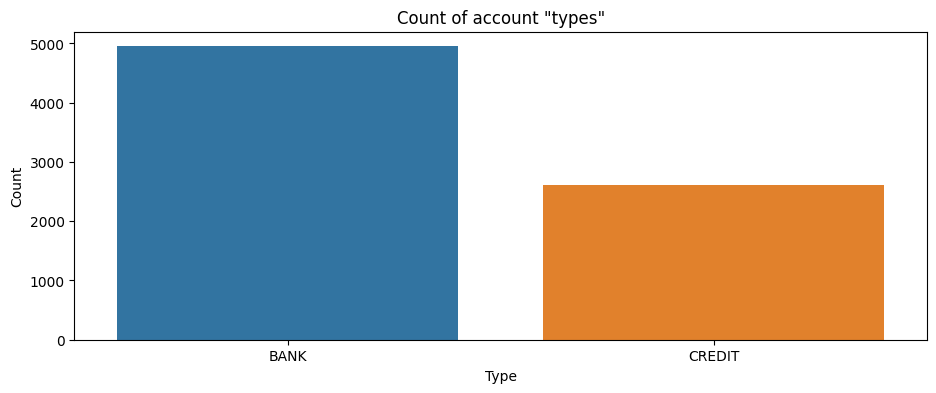

In [37]:
display(accounts["type"].value_counts())

plt.figure(figsize=(11, 4))
sns.barplot(y=accounts["type"].value_counts().values, x=accounts["type"].value_counts().index)
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Count of account "types"')
plt.show()

CREDIT_CARD         2619
CHECKING_ACCOUNT    2509
SAVINGS_ACCOUNT     2441
Name: subtype, dtype: int64

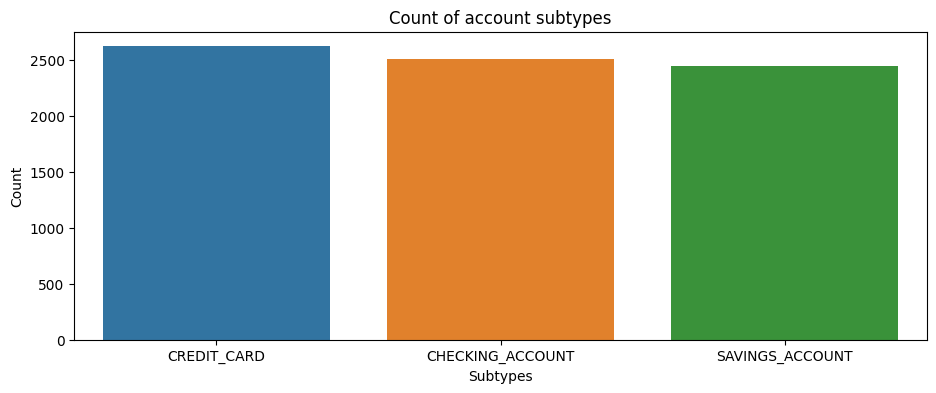

In [38]:
display(accounts["subtype"].value_counts())

plt.figure(figsize=(11, 4))
sns.barplot(y=accounts["subtype"].value_counts().values, x=accounts["subtype"].value_counts().index)
plt.xlabel('Subtypes')
plt.ylabel('Count')
plt.title('Count of account subtypes')
plt.show()

Cartão de Crédito    2619
Conta Corrente       2509
Poupança              845
Conta Remunerada      804
Caixinha              792
Name: name, dtype: int64

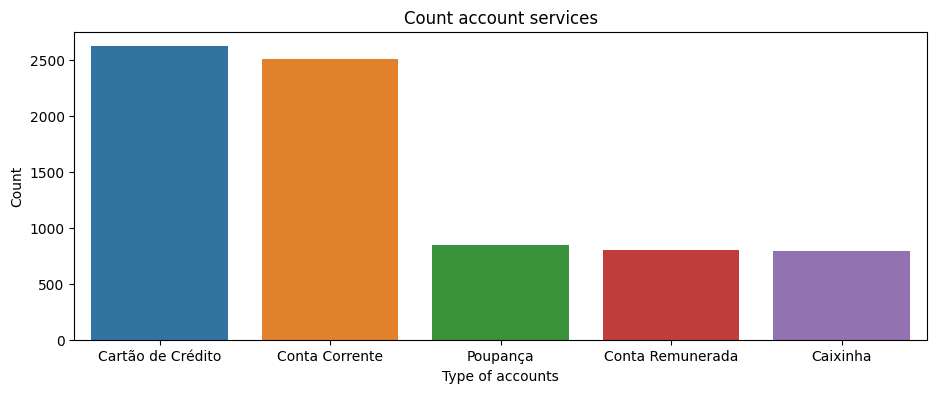

In [39]:
display(accounts["name"].value_counts())

plt.figure(figsize=(11, 4))
sns.barplot(y=accounts["name"].value_counts().values, x=accounts["name"].value_counts().index)
plt.xlabel('Type of accounts')
plt.ylabel('Count')
plt.title('Count account services')
plt.show()

### Transactions

In [40]:
transactions.shape

(400110, 5)

In [41]:
display(transactions.head())
display(transactions.tail())

,id,amount,category,account_id,date_trans
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,498.71,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-20
1,b8d83679-02ab-4241-b15d-11e9c0033864,265.00,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-23
2,99cab263-da5c-4706-9f2c-92cb779acaf7,18.95,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-26
3,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,262.70,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-21
4,fc4e9552-bb41-4757-8c16-ff2c584ee01b,179.44,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-08-05


,id,amount,category,account_id,date_trans
400105,95d79cc9-988c-4811-81f8-ffe910092074,2185.20,Recebido,df03df9a-b7e3-4ee3-b2d5-50275e41afcf,2022-12-02
400106,eac2684b-c13b-44c2-8efb-79fbf9c4cd75,2274.47,Recebido,7dbe31db-bad3-4820-91c1-94e85a44a7aa,2023-07-22
400107,f1452582-06f3-47ce-bb13-2a2adb8a6cbe,7328.84,Recebido,a67cf9c0-9209-47b7-89dc-cc06c4c39d81,2023-07-24
400108,1db037b4-fe8c-48f5-92f0-10c753f5330f,7328.84,Recebido,a67cf9c0-9209-47b7-89dc-cc06c4c39d81,2023-06-25
400109,c2b4de56-d6bc-4b4f-b7c5-4c0aea79a129,5081.83,Recebido,1d6c9df7-a0aa-4435-a6a9-97590c05d52c,2023-06-17


In [42]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400110 entries, 0 to 400109
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          400110 non-null  object 
 1   amount      400110 non-null  float64
 2   category    368501 non-null  object 
 3   account_id  400110 non-null  object 
 4   date_trans  400110 non-null  object 
dtypes: float64(1), object(4)
memory usage: 15.3+ MB


In [43]:
print("max", transactions.date_trans.max())
print("min", transactions.date_trans.min())

max 2023-09-15
min 2022-01-03


2023/7     136331
2023/8     132728
2023/6      62929
2023/9      62076
2023/5       4111
2023/4       1098
2023/3        363
2023/2        182
2023/1        117
2022/12        70
2022/11        38
2022/10        20
2022/9         16
2022/8          7
2022/7          5
2022/6          5
2022/5          3
2022/4          3
2022/3          3
2022/1          3
2022/2          2
Name: year_month_trans, dtype: int64

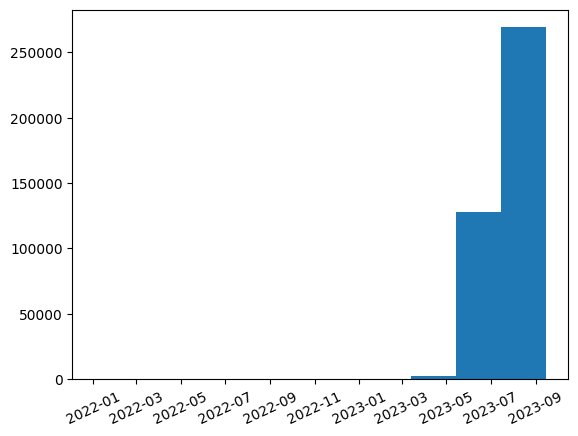

In [44]:
transactions['year_month_trans'] = transactions.date_trans.map(lambda x:str(x.year))+"/"+transactions.date_trans.map(lambda x:str(x.month))
display(transactions['year_month_trans'].value_counts())

plt.hist(transactions.date_trans, bins=10)
plt.xticks(rotation=25)
plt.show()

In [45]:
filtered_null_category = transactions[transactions['category'].isnull()]
filtered_null_category

,id,amount,category,account_id,date_trans,year_month_trans
8,437feea8-3afd-4f2f-9c98-91de4575b57b,1258.65,NaN,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-19,2023/6
12,ef335bda-b208-40b3-abee-46de72b5a0b3,199.70,NaN,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-22,2023/6
68,96b1c62c-e319-40e5-a201-69432b145fd3,535.54,NaN,978f92cf-8d5b-437a-a046-cdaa9105624c,2023-08-16,2023/8
76,024227f9-af91-4ce0-b4e7-d6d243dd9153,2436.43,NaN,978f92cf-8d5b-437a-a046-cdaa9105624c,2023-09-13,2023/9
87,c12a1b96-92d2-4541-bb85-472959819a30,1786.20,NaN,978f92cf-8d5b-437a-a046-cdaa9105624c,2023-08-27,2023/8
...,...,...,...,...,...,...
380109,111d167f-9ba0-4918-a689-0db641cb8f46,7351.86,NaN,e3ca889d-2b1c-464a-be4f-b7719822ba98,2023-09-03,2023/9
380113,b6929181-a07a-42d1-a32e-6ddafc2774be,1426.42,NaN,e3ca889d-2b1c-464a-be4f-b7719822ba98,2023-08-23,2023/8
380145,52ce02f0-321e-4c30-9cdf-387aa0b67413,6277.14,NaN,8c709383-2d35-4796-995f-3eea8e7fefd9,2023-08-11,2023/8
380158,9d7623d3-9ef3-4151-ae50-6e72fee99634,4825.69,NaN,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,2023-07-26,2023/7


In [46]:
print(f"The dataframe has {len(filtered_null_category)} missing values in the suitability of a total of {len(transactions)}: {round((len(filtered_null_category)/len(transactions)*100),1)}%")

The dataframe has 31609 missing values in the suitability of a total of 400110: 7.9%


In [47]:
transactions['category'].fillna("no_category", inplace=True)

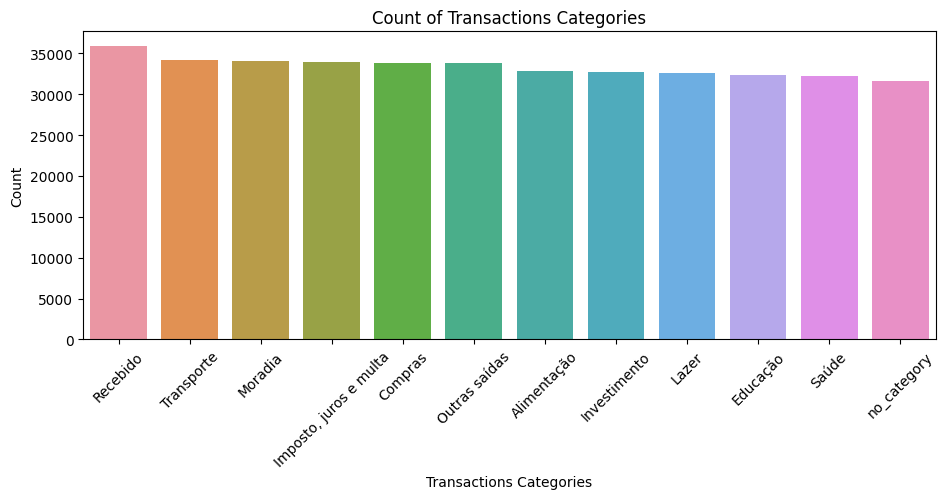

In [48]:
transactions["category"].value_counts()

plt.figure(figsize=(11, 4))
sns.barplot(y=transactions["category"].value_counts().values, x=transactions["category"].value_counts().index)
plt.xlabel('Transactions Categories')
plt.ylabel('Count')
plt.title('Count of Transactions Categories')
plt.xticks(rotation=45)
plt.show()

In [49]:
transactions.describe()

,amount
count,400110.000000
mean,1192.511743
std,1692.519860
min,10.100000
25%,216.900000
50%,592.110000
75%,1553.435000
max,29334.350000


In [50]:
transactions.duplicated().sum()

0

<AxesSubplot: >

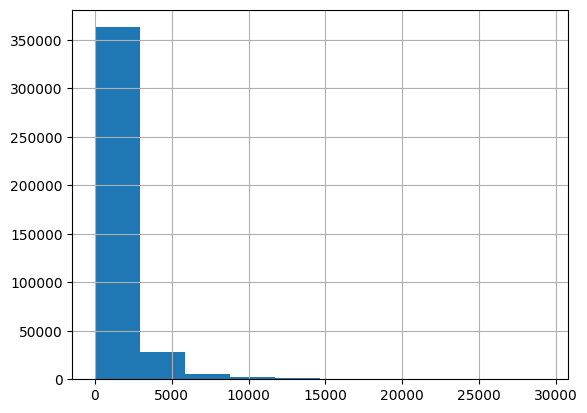

In [51]:
transactions.amount.hist()

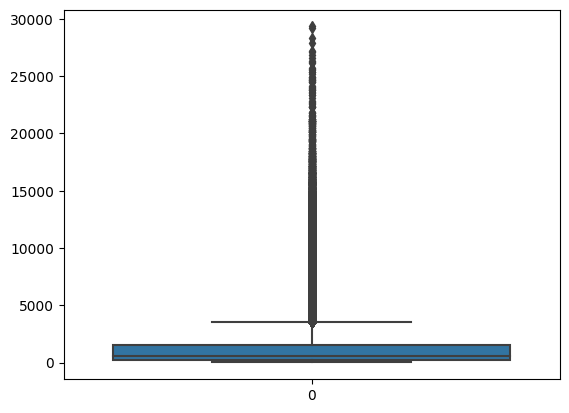

In [52]:
sns.boxplot(transactions.amount)
plt.show()

# Merge dataframes

In [53]:
person_merge = person[['id', 'suitability']]
accounts_merge = accounts[['id', 'balance', 'name', 'person_id', 'date_acc', "year_month_acc"]]
transactions_merge = transactions[['id', 'amount', 'date_trans', 'category', 'account_id', 'year_month_trans']]

In [54]:
merged_accounts = pd.merge(person_merge, accounts_merge, left_on="id", right_on="person_id", how="left", suffixes=("_person", "_acc"))

In [55]:
merged_accounts

,id_person,suitability,id_acc,balance,name,person_id,date_acc,year_month_acc
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14,2023/9
1,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,978f92cf-8d5b-437a-a046-cdaa9105624c,6311.67,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-15,2023/9
2,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,dcd96f70-8b16-42b0-a944-afec5d8305ce,7482.25,Cartão de Crédito,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-09,2023/9
3,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,6c2a44fe-2ba7-4626-aaff-f244a0647eae,5740.29,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-12,2023/9
4,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,abb359a2-3802-48e7-976b-8671e1de0884,5136.49,Conta Corrente,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-12,2023/9
...,...,...,...,...,...,...,...,...
7564,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,88f496c6-eac6-422f-8a4d-e88ca3fe0351,12044.12,Poupança,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-15,2023/9
7565,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,e3ca889d-2b1c-464a-be4f-b7719822ba98,12351.60,Cartão de Crédito,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-14,2023/9
7566,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,c64d8afc-409f-446e-a19c-a8c9c0c5e57b,9555.10,Cartão de Crédito,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-08-29,2023/8
7567,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,8c709383-2d35-4796-995f-3eea8e7fefd9,5044.89,Cartão de Crédito,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023-09-15,2023/9


In [56]:
merged_accounts.shape

(7569, 8)

In [57]:
merged_data_total = pd.merge(merged_accounts, transactions, left_on="id_acc", right_on="account_id", how="left", suffixes=("_acc", "_trans"))

In [58]:
merged_data_total.head()

,id_person,suitability,id_acc,balance,name,person_id,date_acc,year_month_acc,id,amount,category,account_id,date_trans,year_month_trans
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14,2023/9,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,498.71,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-20,2023/7
1,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14,2023/9,b8d83679-02ab-4241-b15d-11e9c0033864,265.00,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-23,2023/7
2,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14,2023/9,99cab263-da5c-4706-9f2c-92cb779acaf7,18.95,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-26,2023/6
3,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14,2023/9,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,262.70,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-21,2023/6
4,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,3826.72,Caixinha,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023-09-14,2023/9,fc4e9552-bb41-4757-8c16-ff2c584ee01b,179.44,"Imposto, juros e multa",1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-08-05,2023/8


In [59]:
merged_data_total.columns

Index(['id_person', 'suitability', 'id_acc', 'balance', 'name', 'person_id',
       'date_acc', 'year_month_acc', 'id', 'amount', 'category', 'account_id',
       'date_trans', 'year_month_trans'],
      dtype='object')

In [60]:
df = merged_data_total[['id_person', 'id_acc', 'id', 'suitability', 'date_acc', 'year_month_acc','balance', 'name','date_trans','year_month_trans', 'category', 'amount']]
df = df.rename(columns={'id': 'id_trans', 'name':'acc_type'})

In [61]:
df.shape

(400110, 12)

In [62]:
display(df.head())
display(df.tail())

,id_person,id_acc,id_trans,suitability,date_acc,year_month_acc,balance,acc_type,date_trans,year_month_trans,category,amount
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-07-20,2023/7,Educação,498.71
1,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,b8d83679-02ab-4241-b15d-11e9c0033864,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-07-23,2023/7,Outras saídas,265.00
2,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,99cab263-da5c-4706-9f2c-92cb779acaf7,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-06-26,2023/6,Transporte,18.95
3,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-06-21,2023/6,Outras saídas,262.70
4,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,fc4e9552-bb41-4757-8c16-ff2c584ee01b,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-08-05,2023/8,"Imposto, juros e multa",179.44


,id_person,id_acc,id_trans,suitability,date_acc,year_month_acc,balance,acc_type,date_trans,year_month_trans,category,amount
400105,fabc96ce-3723-42dc-8cbe-0aba93fcd773,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,d1297b29-1168-4f15-b856-fc252375d4f7,conservador,2023-09-15,2023/9,3788.95,Poupança,2023-06-20,2023/6,Lazer,735.58
400106,fabc96ce-3723-42dc-8cbe-0aba93fcd773,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,bf174dd6-91b9-4b52-b847-cf814accdb07,conservador,2023-09-15,2023/9,3788.95,Poupança,2023-07-12,2023/7,Saúde,1205.81
400107,fabc96ce-3723-42dc-8cbe-0aba93fcd773,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,b6714ac1-9299-4fb0-bfe8-4ce4bc98604f,conservador,2023-09-15,2023/9,3788.95,Poupança,2023-07-27,2023/7,Saúde,921.22
400108,fabc96ce-3723-42dc-8cbe-0aba93fcd773,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,35c6a2bd-c6d7-450a-910b-cf323b444dbf,conservador,2023-09-15,2023/9,3788.95,Poupança,2023-07-23,2023/7,Compras,2767.55
400109,fabc96ce-3723-42dc-8cbe-0aba93fcd773,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,d52a9f5e-840f-47f2-a9d5-5c45e6086754,conservador,2023-09-15,2023/9,3788.95,Poupança,2023-07-09,2023/7,Investimento,1970.78


In [63]:
df.describe()

,balance,amount
count,400110.000000,400110.000000
mean,5688.566108,1192.511743
std,4758.308835,1692.519860
min,11.520000,10.100000
25%,2540.750000,216.900000
50%,5045.500000,592.110000
75%,7566.560000,1553.435000
max,44965.250000,29334.350000


In [64]:
print('max_trans', df.date_trans.max())
print('min_trans', df.date_trans.min())

print('max_acc', df.date_acc.max())
print('min_acc', df.date_acc.min())

max_trans 2023-09-15
min_trans 2022-01-03
max_acc 2023-09-15
min_acc 2023-06-20


In [65]:
df.duplicated().sum()

0

### 1. Análise Exploratória de Dados - Bivariada

In [66]:
df.head()

,id_person,id_acc,id_trans,suitability,date_acc,year_month_acc,balance,acc_type,date_trans,year_month_trans,category,amount
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-07-20,2023/7,Educação,498.71
1,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,b8d83679-02ab-4241-b15d-11e9c0033864,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-07-23,2023/7,Outras saídas,265.00
2,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,99cab263-da5c-4706-9f2c-92cb779acaf7,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-06-26,2023/6,Transporte,18.95
3,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-06-21,2023/6,Outras saídas,262.70
4,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,fc4e9552-bb41-4757-8c16-ff2c584ee01b,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-08-05,2023/8,"Imposto, juros e multa",179.44


In [67]:
df.columns

Index(['id_person', 'id_acc', 'id_trans', 'suitability', 'date_acc',
       'year_month_acc', 'balance', 'acc_type', 'date_trans',
       'year_month_trans', 'category', 'amount'],
      dtype='object')

In [68]:
def boxplot(x, y, data):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    sns.boxplot(x=x, y=y, data=data)

#     plt.title("Box Plot of Account Balances by Subtype")
#     plt.xlabel("Subtype")
#     plt.ylabel("Balance")

    plt.show()

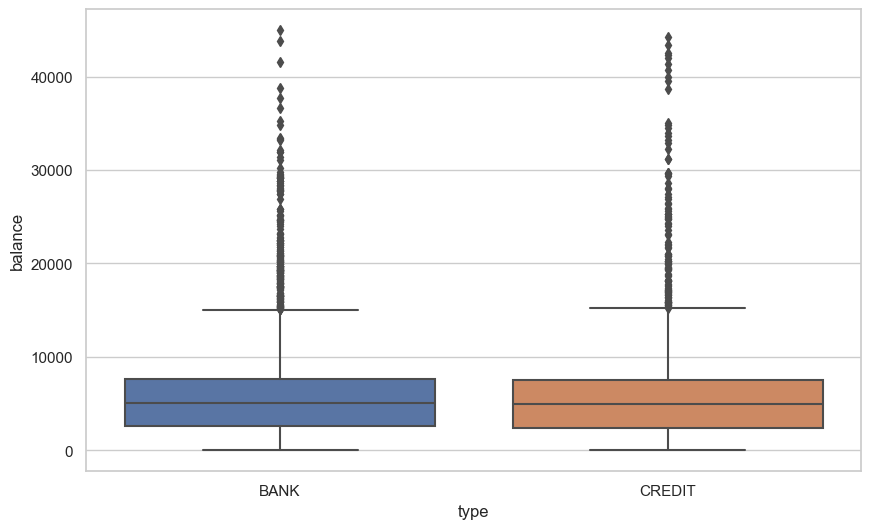

In [69]:
boxplot(x='type', y='balance', data=accounts)

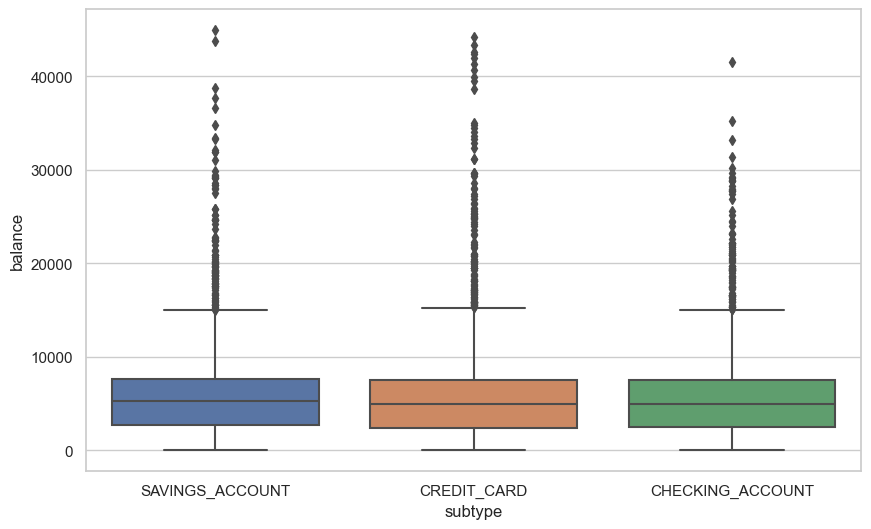

In [70]:
boxplot(x='subtype', y='balance', data=accounts)

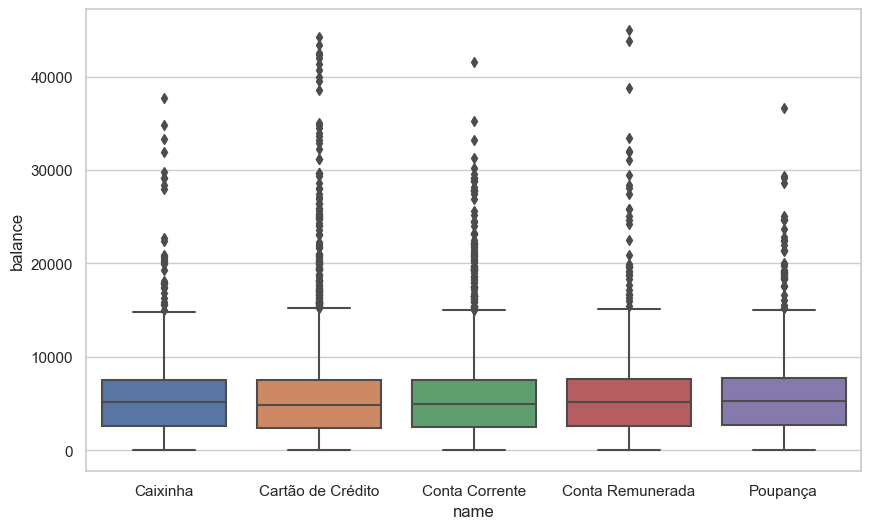

In [71]:
boxplot(x='name', y='balance', data=accounts)

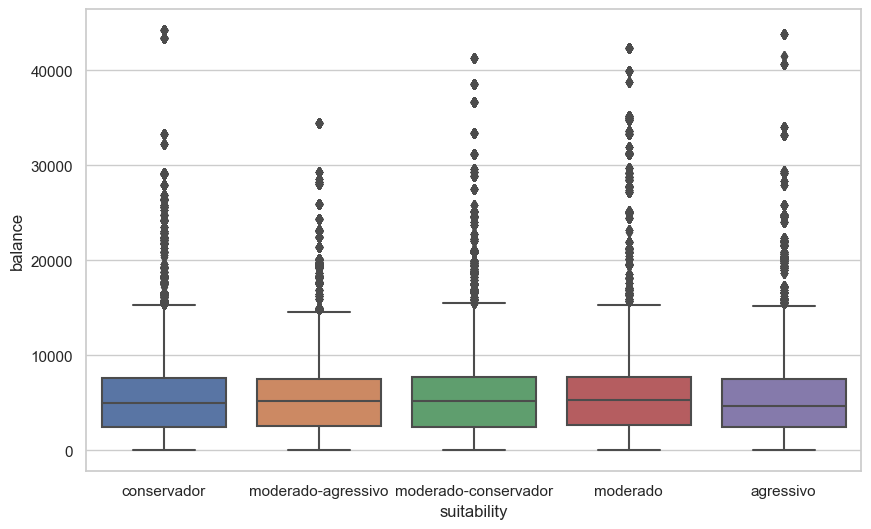

In [72]:
boxplot(x='suitability', y='balance', data=df[df.suitability != "no_suitability"])

In [73]:
df

,id_person,id_acc,id_trans,suitability,date_acc,year_month_acc,balance,acc_type,date_trans,year_month_trans,category,amount
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-07-20,2023/7,Educação,498.71
1,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,b8d83679-02ab-4241-b15d-11e9c0033864,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-07-23,2023/7,Outras saídas,265.00
2,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,99cab263-da5c-4706-9f2c-92cb779acaf7,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-06-26,2023/6,Transporte,18.95
3,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-06-21,2023/6,Outras saídas,262.70
4,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,fc4e9552-bb41-4757-8c16-ff2c584ee01b,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-08-05,2023/8,"Imposto, juros e multa",179.44
...,...,...,...,...,...,...,...,...,...,...,...,...
400105,fabc96ce-3723-42dc-8cbe-0aba93fcd773,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,d1297b29-1168-4f15-b856-fc252375d4f7,conservador,2023-09-15,2023/9,3788.95,Poupança,2023-06-20,2023/6,Lazer,735.58
400106,fabc96ce-3723-42dc-8cbe-0aba93fcd773,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,bf174dd6-91b9-4b52-b847-cf814accdb07,conservador,2023-09-15,2023/9,3788.95,Poupança,2023-07-12,2023/7,Saúde,1205.81
400107,fabc96ce-3723-42dc-8cbe-0aba93fcd773,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,b6714ac1-9299-4fb0-bfe8-4ce4bc98604f,conservador,2023-09-15,2023/9,3788.95,Poupança,2023-07-27,2023/7,Saúde,921.22
400108,fabc96ce-3723-42dc-8cbe-0aba93fcd773,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,35c6a2bd-c6d7-450a-910b-cf323b444dbf,conservador,2023-09-15,2023/9,3788.95,Poupança,2023-07-23,2023/7,Compras,2767.55


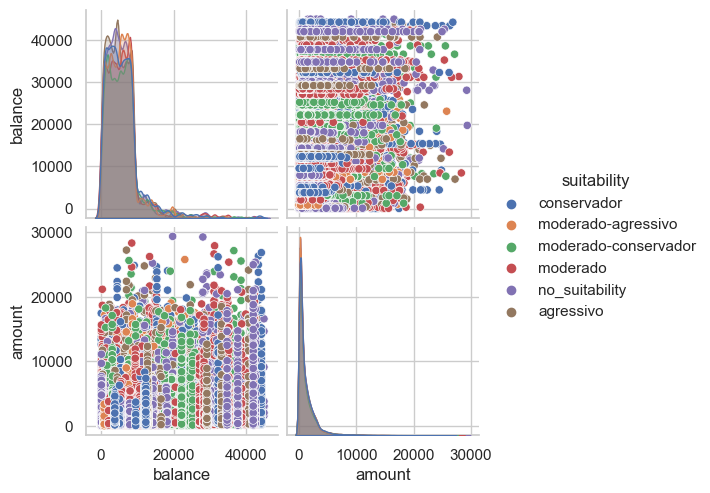

In [74]:
sns.pairplot(df, hue='suitability')

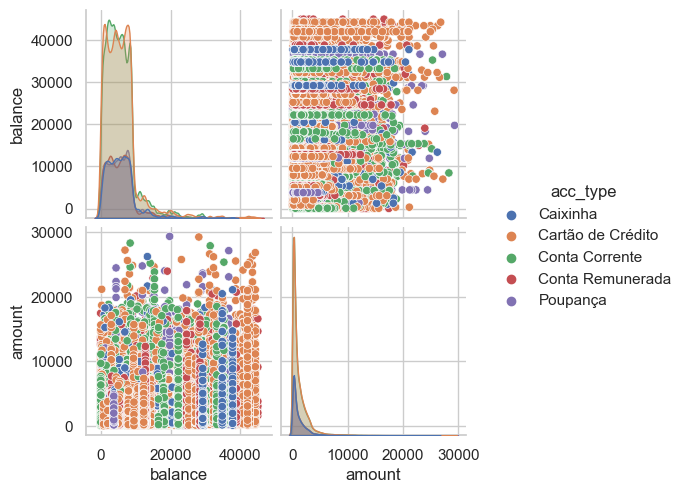

In [75]:
sns.pairplot(df, hue='acc_type')

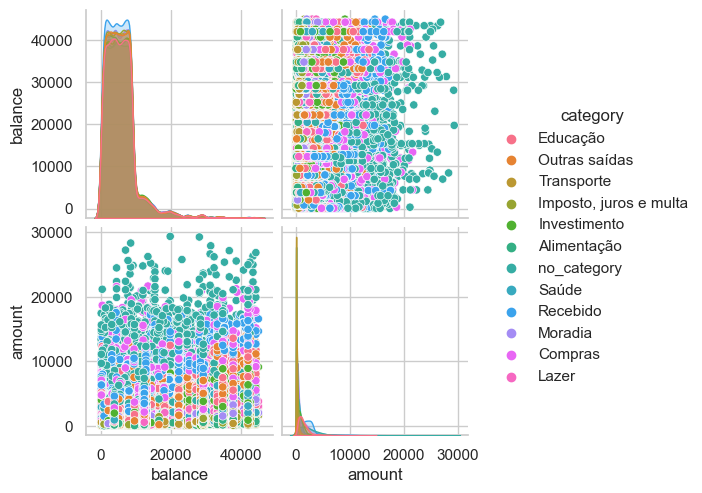

In [76]:
sns.pairplot(df, hue='category')

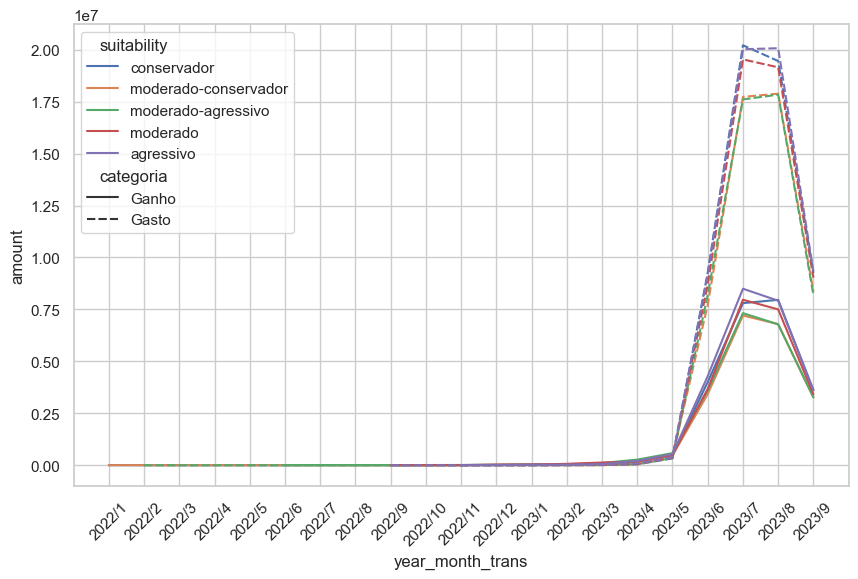

In [77]:
# Filtrar dados para excluir 'no_suitability'
df['year_month_full'] = pd.to_datetime(df.year_month_trans)
df_filtered = df[df['suitability'] != 'no_suitability']

# Criar DataFrames separados para "Gasto" e "Recebido"
df_gastos = df_filtered[~df_filtered['category'].isin(['Investimento', 'Recebido'])]
df_recebidos = df_filtered[df_filtered['category'].isin(['Investimento', 'Recebido'])]

# Agrupar e somar os valores
df_gastos = df_gastos.groupby(['suitability', 'year_month_trans', 'year_month_full'])['amount'].sum().reset_index()
df_recebidos = df_recebidos.groupby(['suitability','year_month_trans', 'year_month_full'])['amount'].sum().reset_index()

# Adicionar uma coluna 'cat' para indicar se é gasto ou recebido
df_gastos['categoria'] = 'Gasto'
df_recebidos['categoria'] = 'Ganho'

# Combinar os DataFrames de gastos e recebidos
df_combined = pd.concat([df_gastos, df_recebidos])

# Criar um gráfico de linhas dividido por "Gasto" e "Recebido"
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_combined.sort_values('year_month_full'), x='year_month_trans', y='amount', 
             hue='suitability', style='categoria')
plt.xticks(rotation=45)
plt.show()

In [78]:
def gasto_recebido_suit(df, suitability): 
    print(suitability.upper())
    # Filtrar dados para excluir 'no_suitability'
    df_filtered = df[df['suitability'] != 'no_suitability']
    df_filtered = df[df['category'] != 'no_category']
    
    df_filtered = df_filtered[df_filtered.suitability == suitability]
    
    # Criar DataFrames separados para "Gasto" e "Recebido"
    df_gastos = df_filtered[~df_filtered['category'].isin(['Investimento', 'Recebido'])]
    df_recebidos = df_filtered[df_filtered['category'].isin(['Investimento', 'Recebido'])]

    # Agrupar e somar os valores
    df_gastos = df_gastos.groupby(['suitability', 'year_month_trans', 'year_month_full'])['amount'].sum().reset_index()
    df_recebidos = df_recebidos.groupby(['suitability', 'year_month_trans', 'year_month_full'])['amount'].sum().reset_index()

    # Adicionar uma coluna 'cat' para indicar se é gasto ou recebido
    df_gastos['categoria'] = 'Gasto'
    df_recebidos['categoria'] = 'Ganho'

    # Combinar os DataFrames de gastos e recebidos
    df_combined = pd.concat([df_gastos, df_recebidos])

    # Criar um gráfico de linhas dividido por "Gasto" e "Recebido"
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_combined.sort_values('year_month_full'), x='year_month_trans', y='amount', 
                 hue='suitability', style='categoria')
    plt.xticks(rotation=45)
    plt.show()

    # Criar um gráfico de linhas dividido por "Gasto" e "Recebido"
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_filtered.sort_values('year_month_full'), x='year_month_trans', y='amount', 
                     hue='category', errorbar=None)
    plt.xticks(rotation=45)
    plt.legend(title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    print("-"*40)

CONSERVADOR


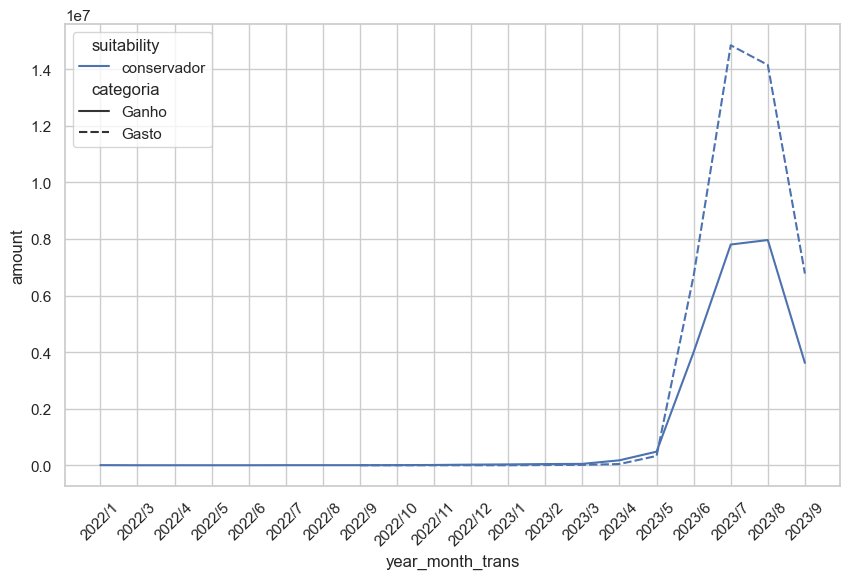

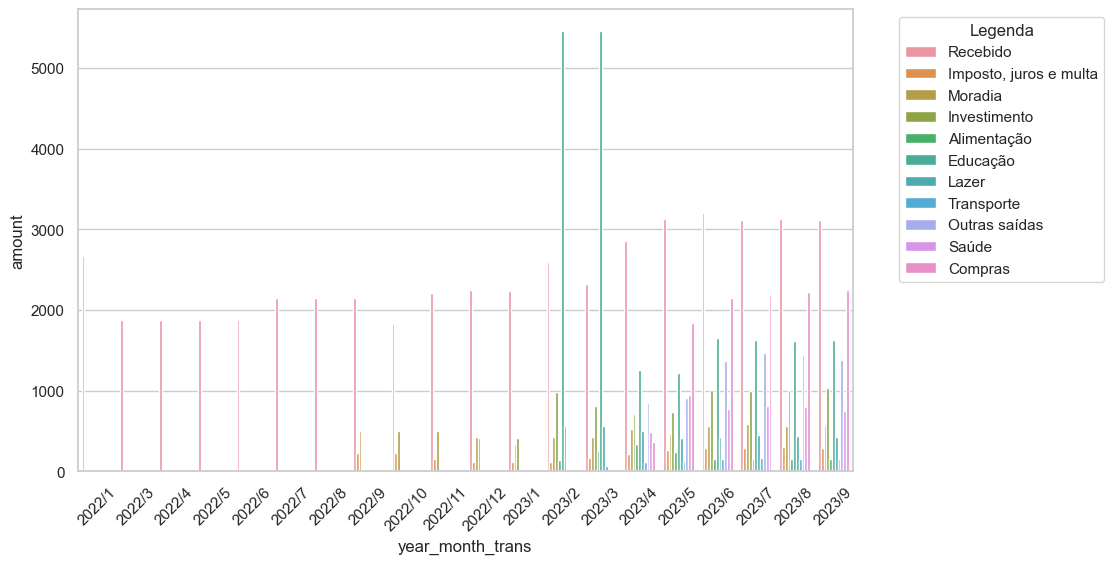

----------------------------------------
MODERADO-AGRESSIVO


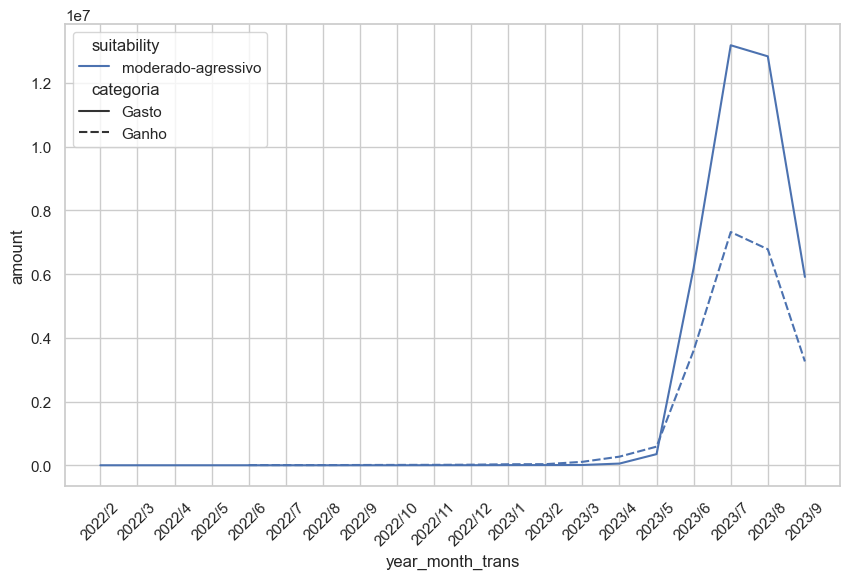

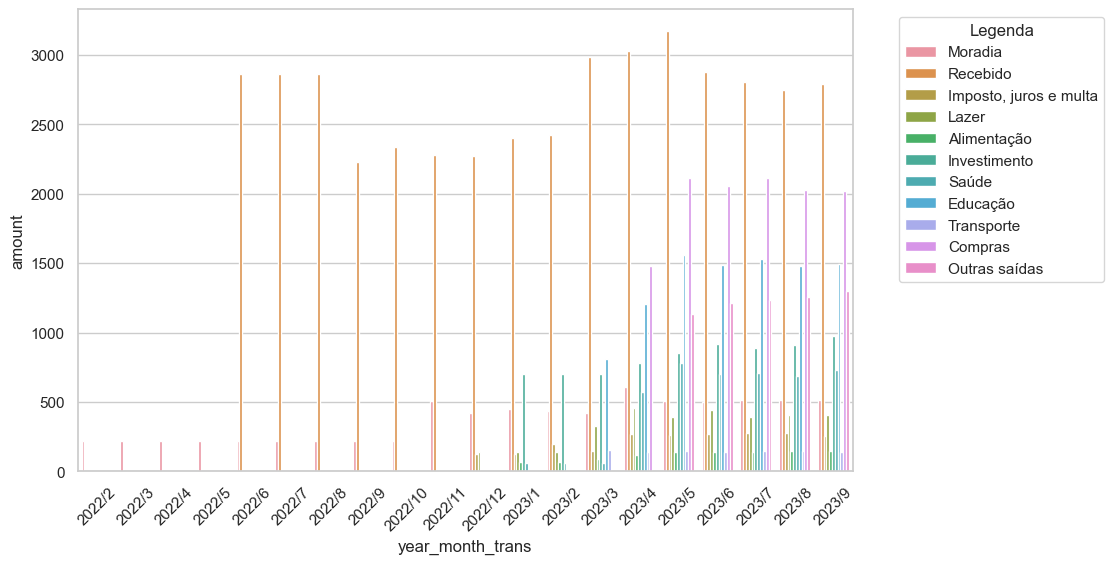

----------------------------------------
MODERADO-CONSERVADOR


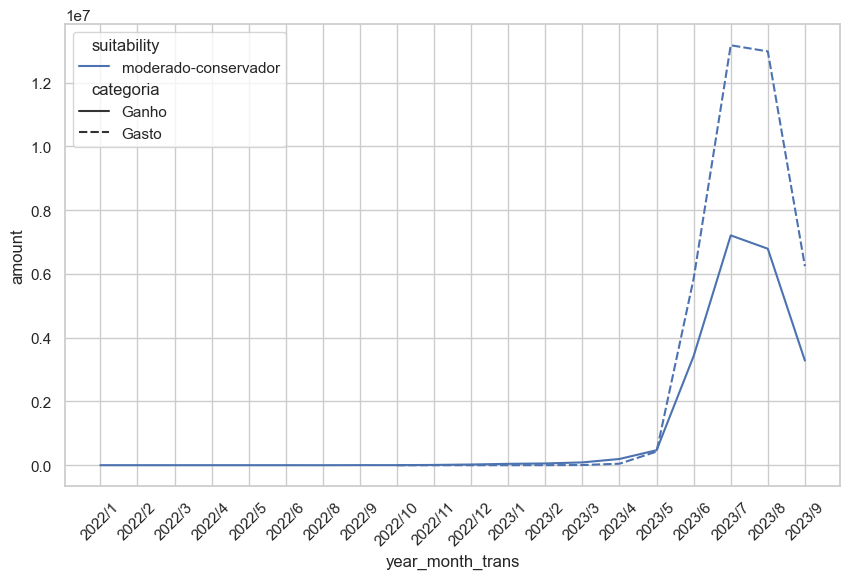

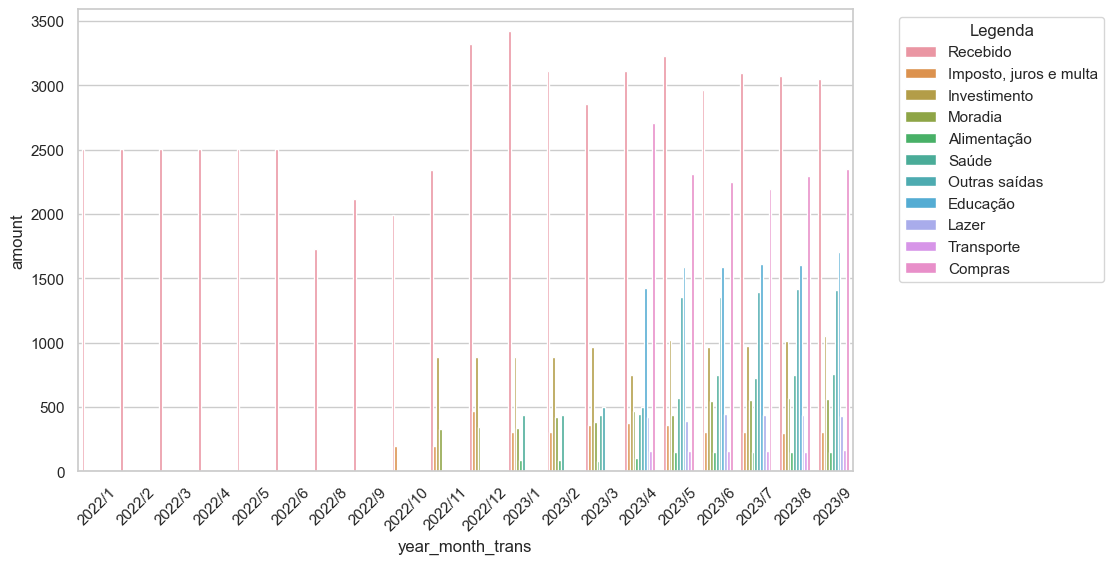

----------------------------------------
MODERADO


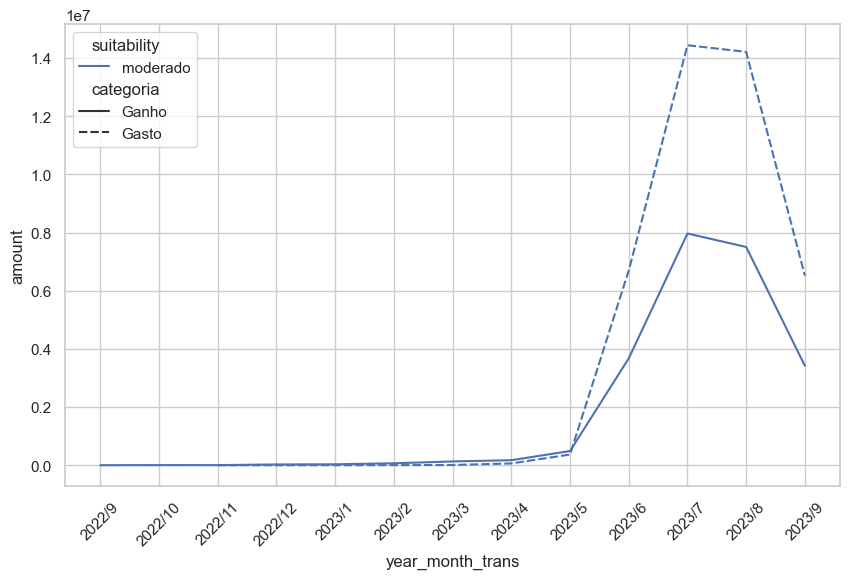

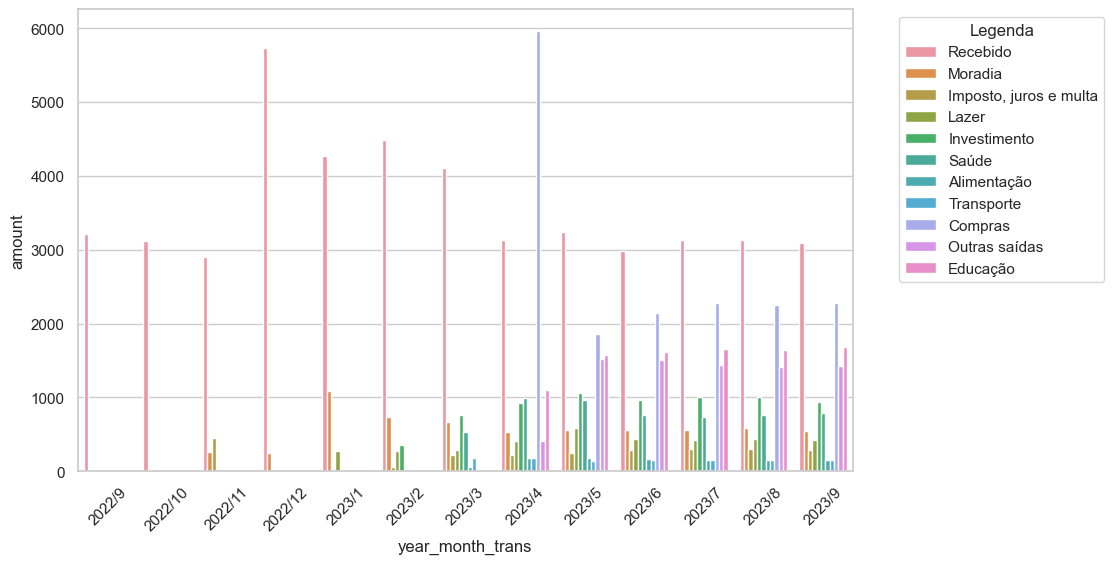

----------------------------------------
NO_SUITABILITY


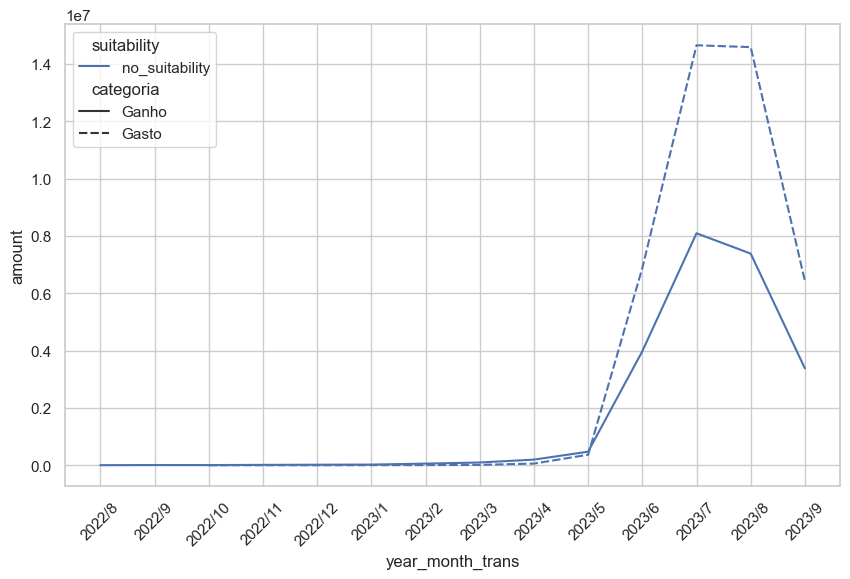

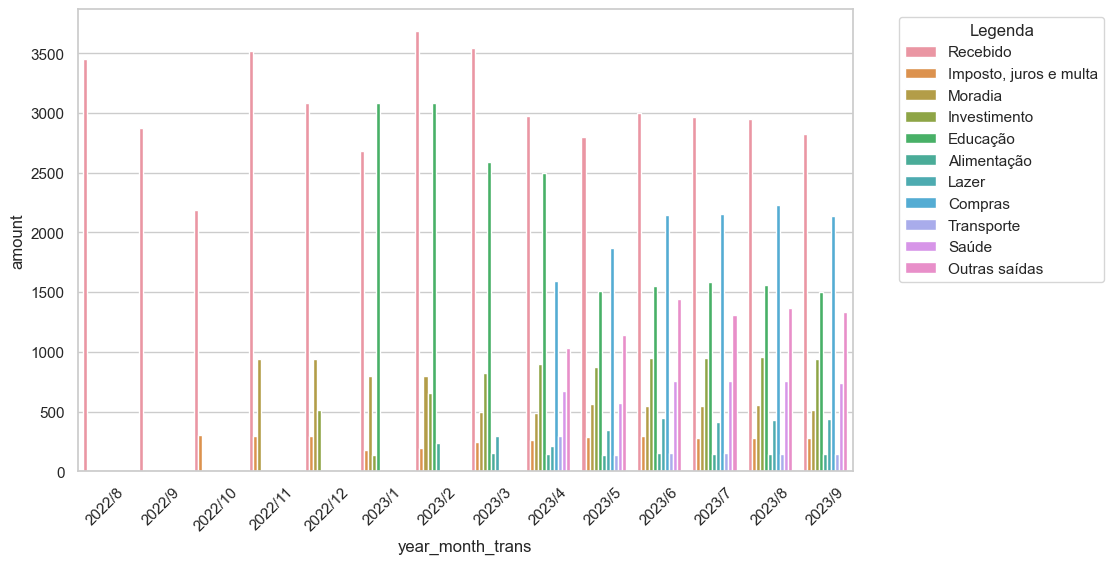

----------------------------------------
AGRESSIVO


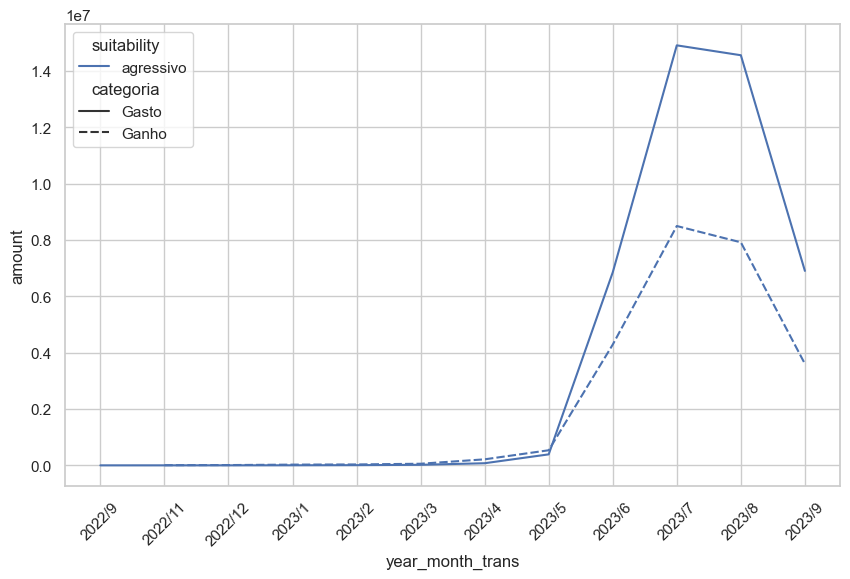

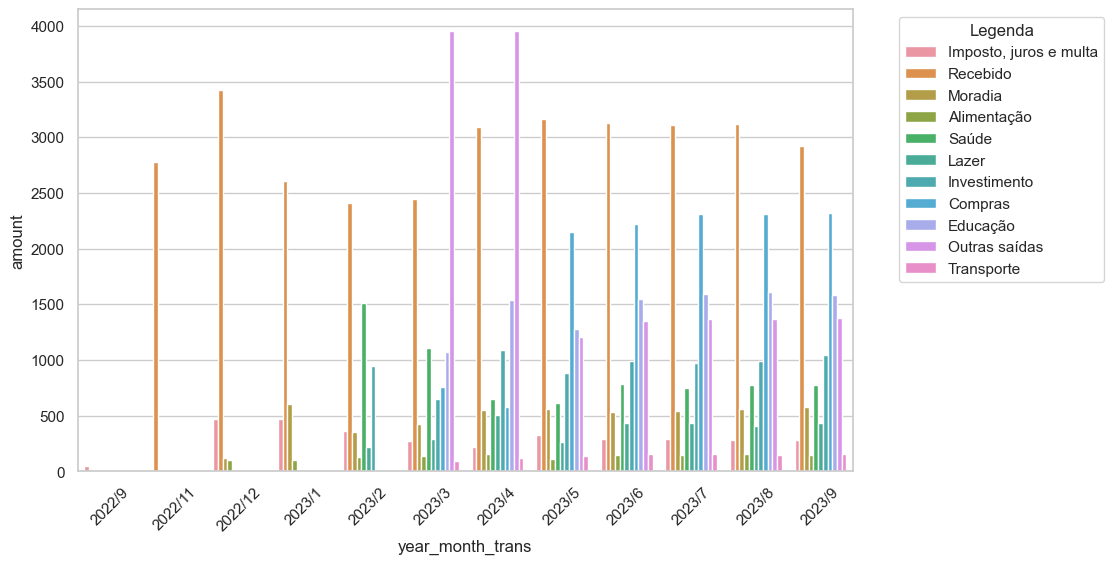

----------------------------------------


In [79]:
for i in df.suitability.unique():
    gasto_recebido_suit(df, i)

In [80]:
def gasto_recebido(df, id_person): 
    # Filtrar dados para excluir 'no_suitability'
    df_filtered = df[df['suitability'] != 'no_suitability']
    df_filtered = df[df['category'] != 'no_category']
    
    df_filtered = df_filtered[df_filtered.id_person == id_person]
    
    # Criar DataFrames separados para "Gasto" e "Recebido"
    df_gastos = df_filtered[~df_filtered['category'].isin(['Investimento', 'Recebido'])]
    df_recebidos = df_filtered[df_filtered['category'].isin(['Investimento', 'Recebido'])]

    # Agrupar e somar os valores
    df_gastos = df_gastos.groupby(['suitability', 'year_month_trans', 'year_month_full'])['amount'].sum().reset_index()
    df_recebidos = df_recebidos.groupby(['suitability', 'year_month_trans', 'year_month_full'])['amount'].sum().reset_index()

    # Adicionar uma coluna 'cat' para indicar se é gasto ou recebido
    df_gastos['categoria'] = 'Gasto'
    df_recebidos['categoria'] = 'Ganho'

    # Combinar os DataFrames de gastos e recebidos
    df_combined = pd.concat([df_gastos, df_recebidos])

    # Criar um gráfico de linhas dividido por "Gasto" e "Recebido"
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_combined.sort_values('year_month_full'), x='year_month_trans', y='amount', 
                 hue='suitability', style='categoria')
    plt.xticks(rotation=45)
    plt.show()

    # Criar um gráfico de linhas dividido por "Gasto" e "Recebido"
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_filtered.sort_values('year_month_full'), x='year_month_trans', y='amount', 
                     hue='category', errorbar=None)
    plt.xticks(rotation=45)
    plt.legend(title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

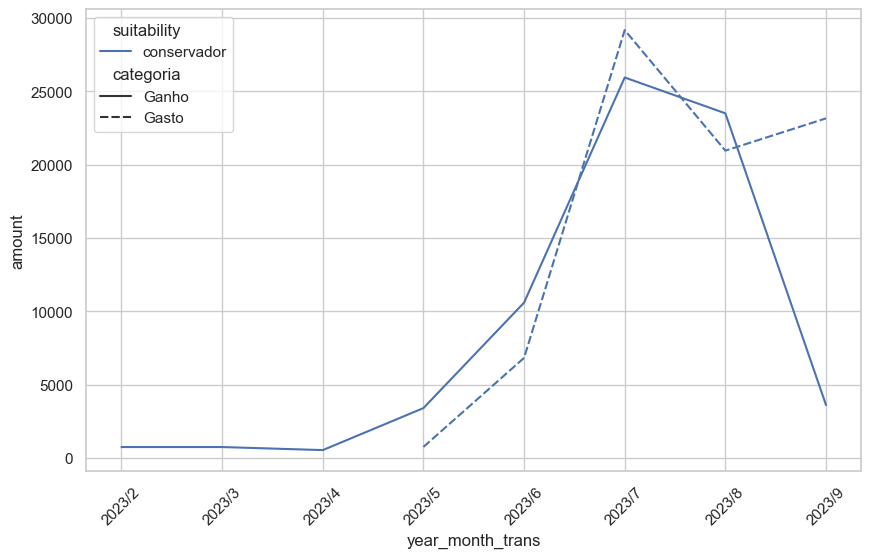

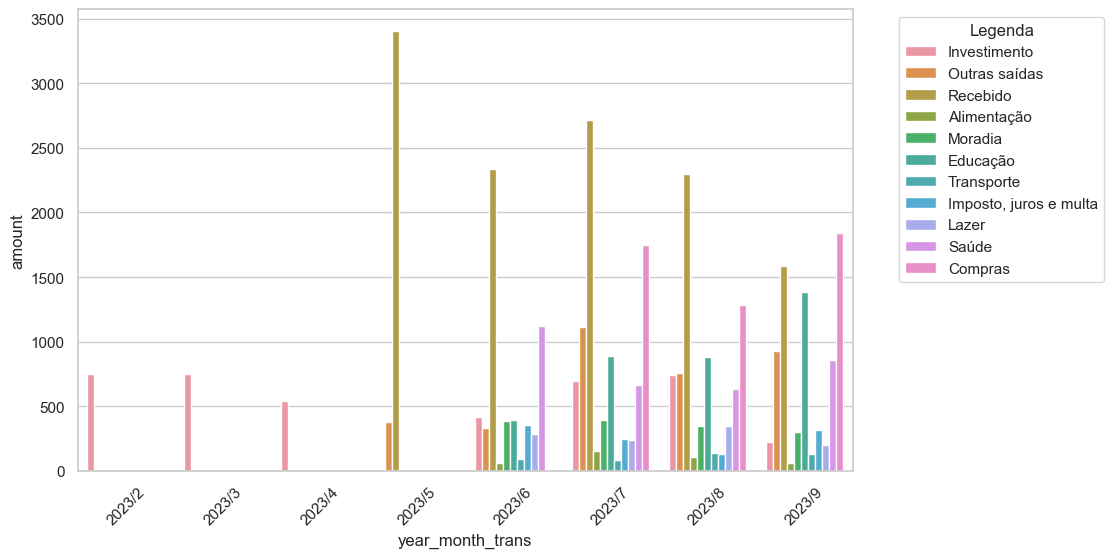

In [81]:
#Exemplo:
gasto_recebido(df, '644f5d18-5bfa-45f9-8aa7-401c05b3b9f2')

### 2. Criar uma nova feature que identifique se as transações se referem a gastos fixos ou variáveis.

In [82]:
df

,id_person,id_acc,id_trans,suitability,date_acc,year_month_acc,balance,acc_type,date_trans,year_month_trans,category,amount,year_month_full
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-07-20,2023/7,Educação,498.71,2023-07-01
1,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,b8d83679-02ab-4241-b15d-11e9c0033864,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-07-23,2023/7,Outras saídas,265.00,2023-07-01
2,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,99cab263-da5c-4706-9f2c-92cb779acaf7,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-06-26,2023/6,Transporte,18.95,2023-06-01
3,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,5a78f1f0-f541-440f-9d3d-c8c21373ffc8,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-06-21,2023/6,Outras saídas,262.70,2023-06-01
4,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,1968bd13-dd25-4f88-bccc-5cff92d6811b,fc4e9552-bb41-4757-8c16-ff2c584ee01b,conservador,2023-09-14,2023/9,3826.72,Caixinha,2023-08-05,2023/8,"Imposto, juros e multa",179.44,2023-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
400105,fabc96ce-3723-42dc-8cbe-0aba93fcd773,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,d1297b29-1168-4f15-b856-fc252375d4f7,conservador,2023-09-15,2023/9,3788.95,Poupança,2023-06-20,2023/6,Lazer,735.58,2023-06-01
400106,fabc96ce-3723-42dc-8cbe-0aba93fcd773,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,bf174dd6-91b9-4b52-b847-cf814accdb07,conservador,2023-09-15,2023/9,3788.95,Poupança,2023-07-12,2023/7,Saúde,1205.81,2023-07-01
400107,fabc96ce-3723-42dc-8cbe-0aba93fcd773,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,b6714ac1-9299-4fb0-bfe8-4ce4bc98604f,conservador,2023-09-15,2023/9,3788.95,Poupança,2023-07-27,2023/7,Saúde,921.22,2023-07-01
400108,fabc96ce-3723-42dc-8cbe-0aba93fcd773,9ba71d75-2913-4b7b-b2e8-48acbd23c36b,35c6a2bd-c6d7-450a-910b-cf323b444dbf,conservador,2023-09-15,2023/9,3788.95,Poupança,2023-07-23,2023/7,Compras,2767.55,2023-07-01


In [83]:
def transaction_periodicity(df, transaction_to_check=None):
    df['date_trans'] = pd.to_datetime(df['date_trans'])
    df['month_trans'] = df['date_trans'].dt.month
    df['year_trans'] = df['date_trans'].dt.year
    df['year_month_trans'] = df['year_trans'].astype(str) + "/" + df['month_trans'].astype(str)

    grouped = df.groupby(['category', 'account_id', 'year_month_trans'])['amount'].mean().reset_index()
    grouped_count = df.groupby(['category', 'account_id', 'amount'])['year_month_trans'].count().reset_index()

    df = df.merge(grouped, on=['category', 'account_id', 'year_month_trans'], suffixes=('', '_mean'))
    df = df.merge(grouped_count, on=['category', 'account_id', 'amount'], suffixes=('', '_count'))

    df['fixed_expense'] = False
    df.loc[(df['amount'] == df['amount_mean']) & (df['year_month_trans_count'] != 1), 'fixed_expense'] = True
    
    if transaction_to_check is not None:
        if transaction_to_check is not None:
            transaction = df[df['id'] == transaction_to_check]
            if not transaction.empty:
                category = transaction['category'].values[0]
                expense_type = 'Fixa' if transaction['fixed_expense'].values[0] else 'Variável'
                return f"A transação {transaction_to_check}, da categoria {category}, é {expense_type}"
            else:
                return "Transação não encontrada."
    return df


In [84]:
# Exemplo:
transaction_periodicity(transactions,"25d75edf-c379-41af-ac44-794346c7ba46")

'A transação 25d75edf-c379-41af-ac44-794346c7ba46, da categoria Outras saídas, é Fixa'

In [85]:
df = transactions[transactions.amount < 0]
df_period = transaction_periodicity(transactions)

In [86]:
df_period.fixed_expense.value_counts()

False    387309
True      12801
Name: fixed_expense, dtype: int64

In [87]:
df_period.head()

,id,amount,category,account_id,date_trans,year_month_trans,month_trans,year_trans,amount_mean,year_month_trans_count,fixed_expense
0,b7ebd81b-98f7-47ab-91f3-52bc80be57a6,498.71,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-20,2023/7,7,2023,890.29,1,False
1,d8fc8050-f201-4037-bde3-18d17d1d38b6,1553.85,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-02,2023/7,7,2023,890.29,1,False
2,53073dc0-8aab-4297-8129-83402df68c22,618.31,Educação,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-15,2023/7,7,2023,890.29,1,False
3,b8d83679-02ab-4241-b15d-11e9c0033864,265.00,Outras saídas,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-07-23,2023/7,7,2023,265.00,1,False
4,99cab263-da5c-4706-9f2c-92cb779acaf7,18.95,Transporte,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023-06-26,2023/6,6,2023,18.95,1,False


### 3. Unsupervised Clustering usando K-Means para segmentar os clientes em diferentes perfis de gastos.

In [88]:
accounts.columns

Index(['id', 'type', 'subtype', 'balance', 'name', 'person_id', 'date_acc',
       'year_month_acc'],
      dtype='object')

In [89]:
accounts.shape

(7569, 8)

In [90]:
pivot_table_acc = accounts.pivot_table(
    values=['balance'],
    index=['id','person_id','year_month_acc'],
    columns=['name'],
    aggfunc='sum',
    fill_value=0
).reset_index()
pivot_table_acc.columns = ['_'.join(map(str, col)) if col[1] != '' else col[0] for col in pivot_table_acc.columns]

In [91]:
pivot_table_acc

,id,person_id,year_month_acc,balance_Caixinha,balance_Cartão de Crédito,balance_Conta Corrente,balance_Conta Remunerada,balance_Poupança
0,0000c62a-c0ba-49df-8a3d-682e34672167,f16cbf47-058f-4dd9-abd7-041c69a034de,2023/9,0.00,0.00,6739.18,0.0,0.00
1,00042933-5d75-4bc1-98a6-2070dd7ffeeb,51eee0e8-1690-44dd-b825-7b3c405fce9f,2023/9,0.00,0.00,7817.76,0.0,0.00
2,00073e2a-29fd-491e-930c-62c852a87372,adee2135-bc42-4c4f-a8ec-23c0218eb8be,2023/9,0.00,7216.24,0.00,0.0,0.00
3,001216e2-6e26-4bfa-85b4-91ad461821ad,6745a751-fd32-4a0d-9bed-7f9d23534a3a,2023/9,8289.84,0.00,0.00,0.0,0.00
4,0014100f-e601-4ce6-bcba-bc5fd6115fa8,3fda7b1a-020f-4a86-8cd0-a7da818875ce,2023/9,0.00,5779.39,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...
7564,ffaf58f1-0f3d-41a6-b3fd-6c2c96e0e520,8507fdbc-17e2-48e1-80e8-4fc7464bd30b,2023/8,0.00,0.00,0.00,0.0,14068.17
7565,ffc7b382-2a53-41ae-86ce-159e5d64d8bf,98de1b2e-326b-435c-955d-04e82610327a,2023/9,0.00,5261.24,0.00,0.0,0.00
7566,ffd0f15d-f5f0-4474-ab60-912da0a01373,e1a1c634-39d4-4f9b-b76c-ca1ecaf330ab,2023/9,0.00,7532.27,0.00,0.0,0.00
7567,ffd4bcbd-62be-45d6-990a-9d983c29013c,270e56f1-78be-4ca2-916c-50eaa82c2b31,2023/9,0.00,6276.13,0.00,0.0,0.00


In [92]:
pivot_table_trans = transactions.pivot_table(
    values=['amount'],
    index=['account_id', 'year_month_trans'],
    columns=['category'],
    aggfunc='sum',
    fill_value=0
).reset_index()
pivot_table_trans.columns = ['_'.join(map(str, col)) if col[1] != '' else col[0] for col in pivot_table_trans.columns]


In [93]:
pivot_table_trans_sum = pivot_table_trans.groupby(['account_id','year_month_trans']).sum().reset_index()

In [94]:
pivot_table_trans_sum

,account_id,year_month_trans,amount_Alimentação,amount_Compras,amount_Educação,"amount_Imposto, juros e multa",amount_Investimento,amount_Lazer,amount_Moradia,amount_Outras saídas,amount_Recebido,amount_Saúde,amount_Transporte,amount_no_category
0,0000c62a-c0ba-49df-8a3d-682e34672167,2023/6,87.91,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,52.19,0.00
1,0000c62a-c0ba-49df-8a3d-682e34672167,2023/7,284.22,210.21,1319.53,1055.39,2459.34,645.41,1655.99,1179.22,6297.72,2511.64,32.68,0.00
2,0000c62a-c0ba-49df-8a3d-682e34672167,2023/8,324.56,2658.98,5617.49,85.15,1146.72,296.20,891.33,0.00,7498.53,1789.26,71.35,0.00
3,0000c62a-c0ba-49df-8a3d-682e34672167,2023/9,0.00,0.00,1488.31,0.00,707.31,1043.51,282.28,732.41,0.00,317.29,71.29,975.23
4,00042933-5d75-4bc1-98a6-2070dd7ffeeb,2023/5,0.00,0.00,0.00,0.00,1671.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33594,ffd4bcbd-62be-45d6-990a-9d983c29013c,2023/9,178.53,2560.83,839.95,0.00,0.00,384.73,0.00,1748.36,2097.40,0.00,302.06,2504.02
33595,ffd5d111-f59b-46ef-beb1-27338edc610a,2023/6,0.00,0.00,1056.93,0.00,0.00,0.00,0.00,0.00,0.00,0.00,288.60,0.00
33596,ffd5d111-f59b-46ef-beb1-27338edc610a,2023/7,0.00,2508.53,1514.53,694.45,0.00,0.00,0.00,1513.99,3053.10,2508.44,114.96,0.00
33597,ffd5d111-f59b-46ef-beb1-27338edc610a,2023/8,0.00,0.00,413.62,0.00,0.00,0.00,0.00,1861.15,0.00,0.00,0.00,0.00


In [95]:
merged_accounts_pivot = pd.merge(person_merge, pivot_table_acc, left_on="id", right_on="person_id", how="left", suffixes=("_person", "_acc"))
merged_data_total_pivot = pd.merge(merged_accounts_pivot, pivot_table_trans_sum, left_on="id_acc", right_on="account_id", how="left", suffixes=("_acc", "_trans"))

In [96]:
merged_data_total_pivot

,id_person,suitability,id_acc,person_id,year_month_acc,balance_Caixinha,balance_Cartão de Crédito,balance_Conta Corrente,balance_Conta Remunerada,balance_Poupança,...,amount_Educação,"amount_Imposto, juros e multa",amount_Investimento,amount_Lazer,amount_Moradia,amount_Outras saídas,amount_Recebido,amount_Saúde,amount_Transporte,amount_no_category
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023/9,3826.72,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,3402.67,0.00,0.00,0.00
1,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023/9,3826.72,0.0,0.0,0.0,0.0,...,329.95,282.53,648.10,0.00,418.71,262.70,5295.40,0.00,18.95,1458.35
2,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023/9,3826.72,0.0,0.0,0.0,0.0,...,2670.87,208.85,195.24,0.00,0.00,265.00,9024.46,2011.69,270.26,0.00
3,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023/9,3826.72,0.0,0.0,0.0,0.0,...,2478.66,179.44,2109.26,0.00,707.29,0.00,0.00,676.88,218.85,0.00
4,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,2023/9,3826.72,0.0,0.0,0.0,0.0,...,3213.97,489.82,0.00,69.60,778.11,0.00,0.00,713.40,192.14,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33594,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,c64d8afc-409f-446e-a19c-a8c9c0c5e57b,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023/8,0.00,9555.1,0.0,0.0,0.0,...,6084.26,0.00,3327.52,0.00,890.85,0.00,0.00,425.42,0.00,0.00
33595,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,e3ca889d-2b1c-464a-be4f-b7719822ba98,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023/9,0.00,12351.6,0.0,0.0,0.0,...,3509.63,0.00,1699.86,0.00,0.00,0.00,11317.06,533.43,0.00,9353.86
33596,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,e3ca889d-2b1c-464a-be4f-b7719822ba98,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023/9,0.00,12351.6,0.0,0.0,0.0,...,8991.66,1373.82,3649.96,1106.95,611.60,4603.25,9081.08,1297.90,516.20,0.00
33597,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,e3ca889d-2b1c-464a-be4f-b7719822ba98,fabc96ce-3723-42dc-8cbe-0aba93fcd773,2023/9,0.00,12351.6,0.0,0.0,0.0,...,2658.78,826.10,3248.77,312.39,2948.94,8719.99,3485.44,575.60,1037.52,14014.93


In [97]:
merged_data_total_pivot.drop(columns=['id_acc','person_id', 'account_id'])

,id_person,suitability,year_month_acc,balance_Caixinha,balance_Cartão de Crédito,balance_Conta Corrente,balance_Conta Remunerada,balance_Poupança,year_month_trans,amount_Alimentação,...,amount_Educação,"amount_Imposto, juros e multa",amount_Investimento,amount_Lazer,amount_Moradia,amount_Outras saídas,amount_Recebido,amount_Saúde,amount_Transporte,amount_no_category
0,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,2023/9,3826.72,0.0,0.0,0.0,0.0,2023/5,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,3402.67,0.00,0.00,0.00
1,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,2023/9,3826.72,0.0,0.0,0.0,0.0,2023/6,0.00,...,329.95,282.53,648.10,0.00,418.71,262.70,5295.40,0.00,18.95,1458.35
2,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,2023/9,3826.72,0.0,0.0,0.0,0.0,2023/7,0.00,...,2670.87,208.85,195.24,0.00,0.00,265.00,9024.46,2011.69,270.26,0.00
3,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,2023/9,3826.72,0.0,0.0,0.0,0.0,2023/8,33.80,...,2478.66,179.44,2109.26,0.00,707.29,0.00,0.00,676.88,218.85,0.00
4,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,2023/9,3826.72,0.0,0.0,0.0,0.0,2023/9,67.58,...,3213.97,489.82,0.00,69.60,778.11,0.00,0.00,713.40,192.14,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33594,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,2023/8,0.00,9555.1,0.0,0.0,0.0,2023/8,0.00,...,6084.26,0.00,3327.52,0.00,890.85,0.00,0.00,425.42,0.00,0.00
33595,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,2023/9,0.00,12351.6,0.0,0.0,0.0,2023/6,882.02,...,3509.63,0.00,1699.86,0.00,0.00,0.00,11317.06,533.43,0.00,9353.86
33596,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,2023/9,0.00,12351.6,0.0,0.0,0.0,2023/7,544.20,...,8991.66,1373.82,3649.96,1106.95,611.60,4603.25,9081.08,1297.90,516.20,0.00
33597,fabc96ce-3723-42dc-8cbe-0aba93fcd773,conservador,2023/9,0.00,12351.6,0.0,0.0,0.0,2023/8,299.28,...,2658.78,826.10,3248.77,312.39,2948.94,8719.99,3485.44,575.60,1037.52,14014.93


In [98]:
merged_data_total_pivot.columns

Index(['id_person', 'suitability', 'id_acc', 'person_id', 'year_month_acc',
       'balance_Caixinha', 'balance_Cartão de Crédito',
       'balance_Conta Corrente', 'balance_Conta Remunerada',
       'balance_Poupança', 'account_id', 'year_month_trans',
       'amount_Alimentação', 'amount_Compras', 'amount_Educação',
       'amount_Imposto, juros e multa', 'amount_Investimento', 'amount_Lazer',
       'amount_Moradia', 'amount_Outras saídas', 'amount_Recebido',
       'amount_Saúde', 'amount_Transporte', 'amount_no_category'],
      dtype='object')

In [99]:
merged_data_total_pivot = merged_data_total_pivot.groupby(['id_person', 'suitability', 'id_acc', 'year_month_acc']).agg({
    'balance_Caixinha': 'max',
    'balance_Cartão de Crédito': 'max',
    'balance_Conta Corrente': 'max', 
    'balance_Conta Remunerada': 'max',
    'balance_Poupança': 'max',
    'amount_Alimentação':'median', 
    'amount_Compras':'median', 
    'amount_Educação':'median',
    'amount_Imposto, juros e multa':'median', 
    'amount_Investimento':'median', 
    'amount_Lazer':'median',
    'amount_Moradia':'median', 
    'amount_Outras saídas':'median', 
    'amount_Recebido':'median',
    'amount_Saúde':'median', 
    'amount_Transporte':'median'
}).reset_index()

In [100]:
merged_data_total_pivot[merged_data_total_pivot.id_person == '644f5d18-5bfa-45f9-8aa7-401c05b3b9f2']

,id_person,suitability,id_acc,year_month_acc,balance_Caixinha,balance_Cartão de Crédito,balance_Conta Corrente,balance_Conta Remunerada,balance_Poupança,amount_Alimentação,amount_Compras,amount_Educação,"amount_Imposto, juros e multa",amount_Investimento,amount_Lazer,amount_Moradia,amount_Outras saídas,amount_Recebido,amount_Saúde,amount_Transporte
2988,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,1968bd13-dd25-4f88-bccc-5cff92d6811b,2023/9,3826.72,0.00,0.00,0.0,0.0,0.000,0.0,2478.66,208.85,195.240,0.00,418.710,0.000,3402.67,676.88,192.140
2989,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,6c2a44fe-2ba7-4626-aaff-f244a0647eae,2023/9,5740.29,0.00,0.00,0.0,0.0,0.000,0.0,0.00,153.95,537.570,146.49,0.000,0.000,1831.18,0.00,62.120
2990,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,978f92cf-8d5b-437a-a046-cdaa9105624c,2023/9,0.00,6311.67,0.00,0.0,0.0,28.635,0.0,0.00,0.00,643.465,0.00,189.915,0.000,1101.31,0.00,0.000
2991,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,abb359a2-3802-48e7-976b-8671e1de0884,2023/9,0.00,0.00,5136.49,0.0,0.0,31.000,641.9,1703.09,97.63,87.140,678.95,186.305,1482.525,974.80,697.80,22.735
2992,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,dcd96f70-8b16-42b0-a944-afec5d8305ce,2023/9,0.00,7482.25,0.00,0.0,0.0,0.000,0.0,0.00,0.00,0.000,0.00,0.000,0.000,0.00,0.00,0.000


In [101]:
merged_data_total_pivot = merged_data_total_pivot.groupby(["id_person","suitability","year_month_acc"]).sum().reset_index()

C:\Users\pedro\AppData\Local\Temp\ipykernel_1116\1994623348.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_data_total_pivot = merged_data_total_pivot.groupby(["id_person","suitability","year_month_acc"]).sum().reset_index()


In [102]:
merged_data_total_pivot.year_month_acc.unique()

array(['2023/9', '2023/8', '2023/7', '2023/6'], dtype=object)

In [103]:
merged_data_total_pivot[merged_data_total_pivot.id_person == '644f5d18-5bfa-45f9-8aa7-401c05b3b9f2']

,id_person,suitability,year_month_acc,balance_Caixinha,balance_Cartão de Crédito,balance_Conta Corrente,balance_Conta Remunerada,balance_Poupança,amount_Alimentação,amount_Compras,amount_Educação,"amount_Imposto, juros e multa",amount_Investimento,amount_Lazer,amount_Moradia,amount_Outras saídas,amount_Recebido,amount_Saúde,amount_Transporte
1133,644f5d18-5bfa-45f9-8aa7-401c05b3b9f2,conservador,2023/9,9567.01,13793.92,5136.49,0.0,0.0,59.635,641.9,4181.75,460.43,1463.415,825.44,794.93,1482.525,7309.96,1374.68,276.995


In [104]:
merged_data_total_pivot = merged_data_total_pivot.groupby(["id_person","suitability"]).mean().reset_index()

C:\Users\pedro\AppData\Local\Temp\ipykernel_1116\1275082645.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_data_total_pivot = merged_data_total_pivot.groupby(["id_person","suitability"]).mean().reset_index()


In [105]:
merged_data_total_pivot = merged_data_total_pivot[merged_data_total_pivot.suitability != "no_suitability"]

In [106]:
merged_data_total_pivot

,id_person,suitability,balance_Caixinha,balance_Cartão de Crédito,balance_Conta Corrente,balance_Conta Remunerada,balance_Poupança,amount_Alimentação,amount_Compras,amount_Educação,"amount_Imposto, juros e multa",amount_Investimento,amount_Lazer,amount_Moradia,amount_Outras saídas,amount_Recebido,amount_Saúde,amount_Transporte
0,000be23a-894b-4eca-aa31-5373556f8204,moderado,0.00,17991.93,0.000,11137.60,0.000,386.3200,13737.5350,2339.0450,792.0700,3333.890,2007.7950,968.710,1465.6950,20950.5500,1014.7250,920.2200
1,001de888-9b29-4b8e-95ca-59adc5903f45,moderado-agressivo,5365.67,8417.80,0.000,1740.30,0.000,302.5750,8530.3400,3982.5800,439.2100,2494.910,279.9350,2434.080,3483.4100,9831.8200,2258.6850,188.7450
2,003d603d-a397-473e-a0d0-5c5a62faf0c5,moderado-conservador,0.00,19308.87,8079.360,0.00,5997.255,421.9825,19189.5675,10258.5825,901.1275,8230.490,1085.9575,2982.565,2234.6025,3343.1225,5839.0875,576.5800
3,007acb4a-2a68-4437-85e2-0bbda827360c,agressivo,0.00,8966.13,0.000,0.00,0.000,27.7950,3601.3450,795.2900,308.7750,709.915,375.5800,471.920,968.8100,3690.1150,799.1400,62.9600
4,0084deeb-c9c8-4006-b6f0-8efb8a57533e,agressivo,0.00,5198.37,0.000,0.00,0.000,0.0000,0.0000,522.4750,139.3350,0.000,134.1300,488.105,0.0000,3268.6250,343.8100,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525,ff56abfc-6694-4d34-a56c-c10187915059,moderado-agressivo,5436.84,6440.43,0.000,0.00,8506.520,318.2450,7583.4300,4060.5650,199.6350,1539.505,1079.7300,1615.715,4835.0200,10254.8700,1189.5700,527.6950
2526,ff61dd96-5421-4461-8673-5dd8f40f8377,moderado-conservador,0.00,15888.57,0.000,0.00,0.000,0.0000,3917.5900,0.0000,1764.9600,0.000,823.5300,1576.200,0.0000,0.0000,0.0000,1450.2500
2527,ff6f6163-c1d2-4630-86aa-5d5afee4cd80,conservador,0.00,5522.45,5691.665,0.00,1246.900,168.9150,2127.9500,3536.2950,803.0650,2854.335,580.2150,1086.365,4326.6650,5310.6275,1439.1250,462.2425
2528,ff8ce1d2-dfa2-485e-b19a-d1e7d2520013,moderado-conservador,0.00,7360.97,10507.500,8212.39,0.000,519.3950,12081.9300,5059.3200,966.7550,3968.275,2359.0000,3059.490,3559.7400,9504.3650,3517.2000,616.0700


In [107]:
merged_data_total_pivot.columns

Index(['id_person', 'suitability', 'balance_Caixinha',
       'balance_Cartão de Crédito', 'balance_Conta Corrente',
       'balance_Conta Remunerada', 'balance_Poupança', 'amount_Alimentação',
       'amount_Compras', 'amount_Educação', 'amount_Imposto, juros e multa',
       'amount_Investimento', 'amount_Lazer', 'amount_Moradia',
       'amount_Outras saídas', 'amount_Recebido', 'amount_Saúde',
       'amount_Transporte'],
      dtype='object')

In [108]:
merged_data_total_pivot.corr(numeric_only=True)

,balance_Caixinha,balance_Cartão de Crédito,balance_Conta Corrente,balance_Conta Remunerada,balance_Poupança,amount_Alimentação,amount_Compras,amount_Educação,"amount_Imposto, juros e multa",amount_Investimento,amount_Lazer,amount_Moradia,amount_Outras saídas,amount_Recebido,amount_Saúde,amount_Transporte
balance_Caixinha,1.000000,0.050253,0.089455,-0.014313,-0.044601,0.270850,0.201870,0.204496,0.191555,0.176234,0.235792,0.216623,0.196902,0.235891,0.235092,0.204333
balance_Cartão de Crédito,0.050253,1.000000,0.050484,0.077837,0.013344,0.466921,0.446755,0.463312,0.440249,0.467502,0.465253,0.489675,0.424867,0.490410,0.454815,0.462251
balance_Conta Corrente,0.089455,0.050484,1.000000,0.050075,0.020935,0.405258,0.361387,0.361109,0.355829,0.345253,0.346459,0.352253,0.337284,0.397450,0.391097,0.354502
balance_Conta Remunerada,-0.014313,0.077837,0.050075,1.000000,0.119572,0.210763,0.255922,0.260573,0.297096,0.286557,0.234462,0.266431,0.232870,0.296727,0.243138,0.292973
balance_Poupança,-0.044601,0.013344,0.020935,0.119572,1.000000,0.231313,0.264629,0.230355,0.226180,0.241643,0.232354,0.232431,0.244751,0.244866,0.227651,0.249829
amount_Alimentação,0.270850,0.466921,0.405258,0.210763,0.231313,1.000000,0.730129,0.753745,0.700648,0.727308,0.739092,0.725193,0.726024,0.756733,0.742795,0.734413
amount_Compras,0.201870,0.446755,0.361387,0.255922,0.264629,0.730129,1.000000,0.714945,0.645515,0.713606,0.728769,0.741588,0.718869,0.728006,0.710834,0.691097
amount_Educação,0.204496,0.463312,0.361109,0.260573,0.230355,0.753745,0.714945,1.000000,0.711653,0.701456,0.720205,0.769742,0.736458,0.753938,0.745602,0.735594
"amount_Imposto, juros e multa",0.191555,0.440249,0.355829,0.297096,0.226180,0.700648,0.645515,0.711653,1.000000,0.711734,0.724150,0.726408,0.701069,0.732868,0.699771,0.732839
amount_Investimento,0.176234,0.467502,0.345253,0.286557,0.241643,0.727308,0.713606,0.701456,0.711734,1.000000,0.722246,0.747974,0.721180,0.760142,0.718138,0.743683


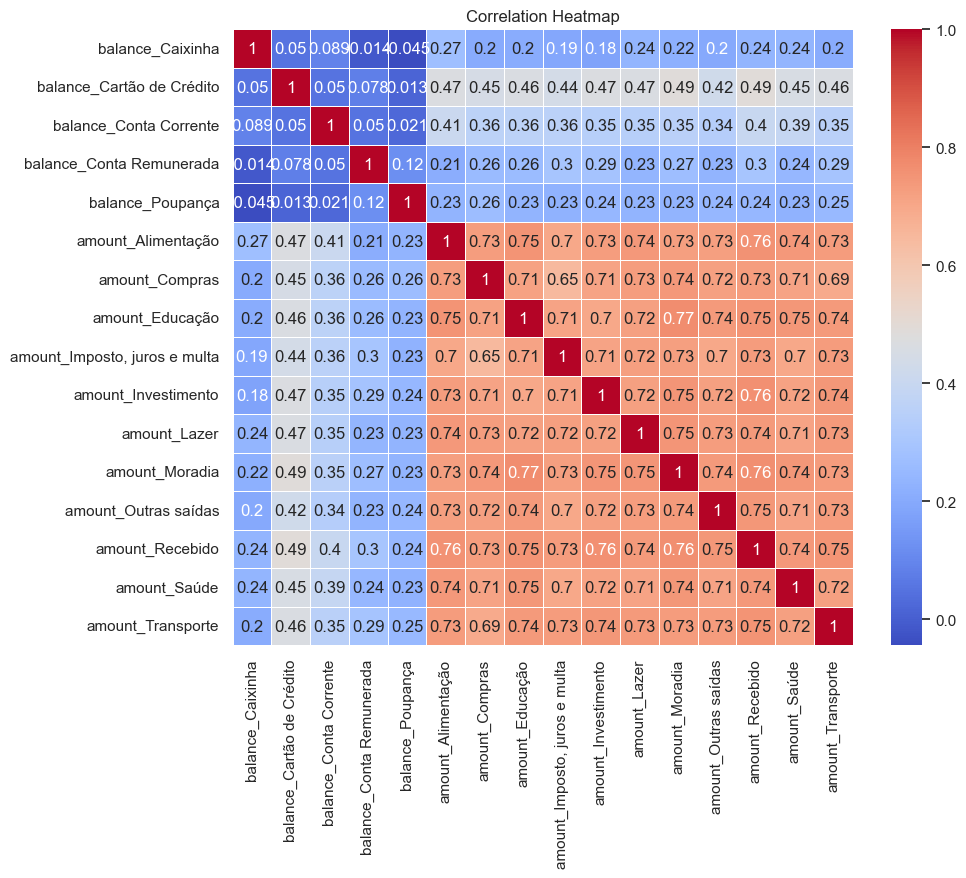

In [109]:
# Assuming merged_data_total_pivot is your DataFrame
corr_matrix = merged_data_total_pivot.corr(numeric_only=True)

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

In [110]:
# Selecionar apenas as colunas que serão usadas na clusterização
data = merged_data_total_pivot[['amount_Alimentação','amount_Compras', 'amount_Educação', 'amount_Imposto, juros e multa',
        'amount_Lazer', 'amount_Moradia','amount_Outras saídas', 'amount_Saúde',
       'amount_Transporte']]

# Normalizar os dados (importante para o K-Means)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

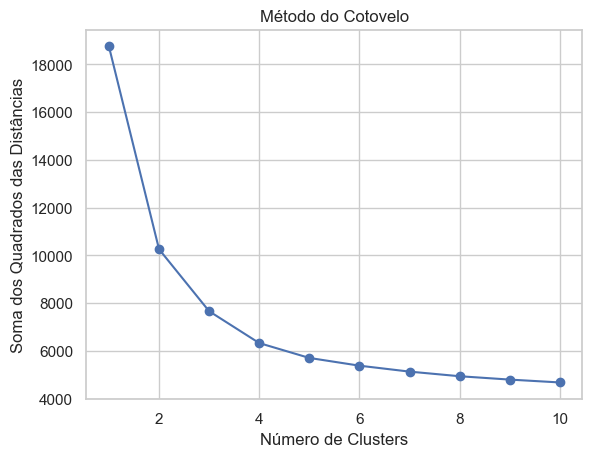

In [111]:
# Suponha que você já tenha os dados normalizados (data_scaled)
# Vamos testar o número de clusters de 1 a 10
inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Soma dos Quadrados das Distâncias')
plt.show()

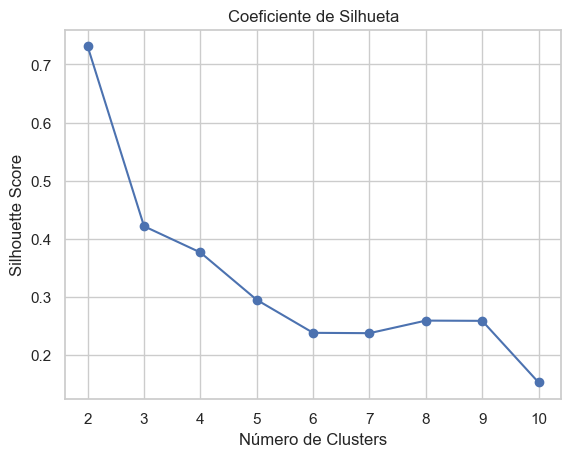

In [112]:
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    cluster_labels = kmeans.fit_predict(data_scaled)
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Coeficiente de Silhueta')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()

***Aplicar PCA nas Variáveis Relevantes***

Agora que você tem clusters, pode escolher quais variáveis são relevantes para o perfil do cliente. 
Após a seleção, você pode aplicar a PCA para reduzir a dimensionalidade.

In [113]:
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(data_scaled)

C:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


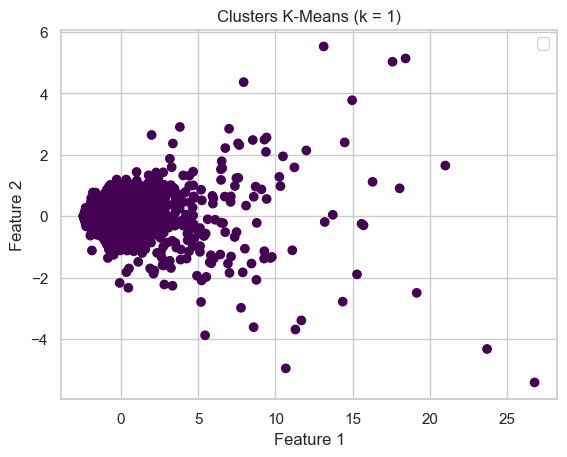

C:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


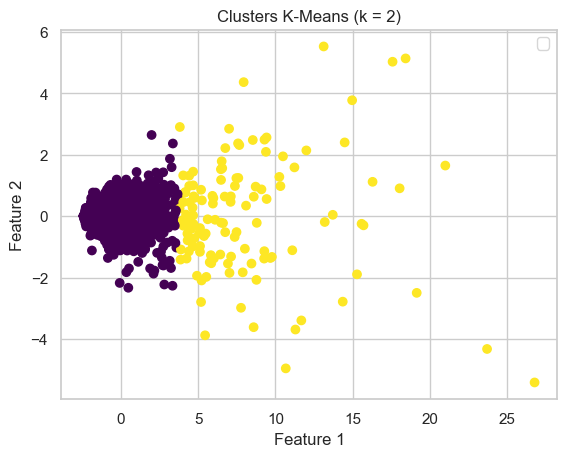

C:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


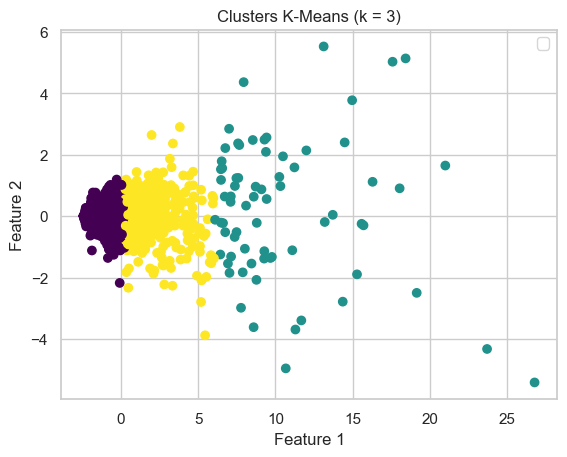

In [115]:
# Escolher o número de clusters (você pode ajustar esse valor)
n_clusters = 3

for i in range(1, n_clusters + 1):
    # Apply the K-Means algorithm
    kmeans = KMeans(n_clusters=i, random_state=0)
    clusters = kmeans.fit_predict(data_scaled)

    # Add the cluster labels to the data
    merged_data_total_pivot['cluster'] = clusters

    # Visualize the clusters (using the two first columns of data)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
    plt.title(f'Clusters K-Means (k = {i})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    
    plt.legend()
    plt.show()

### 3. Unsupervised Clustering usando KNN para segmentar os clientes em diferentes perfis de gastos.

In [117]:
merged_data_total_pivot

,id_person,suitability,balance_Caixinha,balance_Cartão de Crédito,balance_Conta Corrente,balance_Conta Remunerada,balance_Poupança,amount_Alimentação,amount_Compras,amount_Educação,"amount_Imposto, juros e multa",amount_Investimento,amount_Lazer,amount_Moradia,amount_Outras saídas,amount_Recebido,amount_Saúde,amount_Transporte,cluster
0,000be23a-894b-4eca-aa31-5373556f8204,moderado,0.00,17991.93,0.000,11137.60,0.000,386.3200,13737.5350,2339.0450,792.0700,3333.890,2007.7950,968.710,1465.6950,20950.5500,1014.7250,920.2200,2
1,001de888-9b29-4b8e-95ca-59adc5903f45,moderado-agressivo,5365.67,8417.80,0.000,1740.30,0.000,302.5750,8530.3400,3982.5800,439.2100,2494.910,279.9350,2434.080,3483.4100,9831.8200,2258.6850,188.7450,2
2,003d603d-a397-473e-a0d0-5c5a62faf0c5,moderado-conservador,0.00,19308.87,8079.360,0.00,5997.255,421.9825,19189.5675,10258.5825,901.1275,8230.490,1085.9575,2982.565,2234.6025,3343.1225,5839.0875,576.5800,2
3,007acb4a-2a68-4437-85e2-0bbda827360c,agressivo,0.00,8966.13,0.000,0.00,0.000,27.7950,3601.3450,795.2900,308.7750,709.915,375.5800,471.920,968.8100,3690.1150,799.1400,62.9600,0
4,0084deeb-c9c8-4006-b6f0-8efb8a57533e,agressivo,0.00,5198.37,0.000,0.00,0.000,0.0000,0.0000,522.4750,139.3350,0.000,134.1300,488.105,0.0000,3268.6250,343.8100,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525,ff56abfc-6694-4d34-a56c-c10187915059,moderado-agressivo,5436.84,6440.43,0.000,0.00,8506.520,318.2450,7583.4300,4060.5650,199.6350,1539.505,1079.7300,1615.715,4835.0200,10254.8700,1189.5700,527.6950,2
2526,ff61dd96-5421-4461-8673-5dd8f40f8377,moderado-conservador,0.00,15888.57,0.000,0.00,0.000,0.0000,3917.5900,0.0000,1764.9600,0.000,823.5300,1576.200,0.0000,0.0000,0.0000,1450.2500,2
2527,ff6f6163-c1d2-4630-86aa-5d5afee4cd80,conservador,0.00,5522.45,5691.665,0.00,1246.900,168.9150,2127.9500,3536.2950,803.0650,2854.335,580.2150,1086.365,4326.6650,5310.6275,1439.1250,462.2425,0
2528,ff8ce1d2-dfa2-485e-b19a-d1e7d2520013,moderado-conservador,0.00,7360.97,10507.500,8212.39,0.000,519.3950,12081.9300,5059.3200,966.7550,3968.275,2359.0000,3059.490,3559.7400,9504.3650,3517.2000,616.0700,2


In [135]:
# Assuming 'suitability' is your target variable, and you have feature variables
X = merged_data_total_pivot.drop(columns=['id_person', 'suitability'])
y = dummies  # The dummy variables you created

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# For classification:
k = 3  # You can choose the number of neighbors (k) based on cross-validation
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [137]:
# For classification:
y_pred = knn_classifier.predict(X_test)

In [138]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.11031175059952038


In [139]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.25947242206235016


In [144]:
from sklearn.metrics import hamming_loss

hamming_loss_value = hamming_loss(y_test, y_pred)
print(f'cm: {hamming_loss_value}')

cm: 0.2594724220623501


In [145]:
from sklearn.metrics import jaccard_score

jaccard_score_value = jaccard_score(y_test, y_pred, average='samples')
print(f'jaccard_score_value: {jaccard_score_value}')

jaccard_score_value: 0.11031175059952038


In [146]:
from sklearn.metrics import average_precision_score

average_precision_value = average_precision_score(y_test, y_pred)
print(f'average_precision_value: {average_precision_value}')

average_precision_value: 0.20285662561303708


### 4. Etiquetar cada cluster identificado com padrões de gastos quanto à quantidade, natureza (fixo/variado) e categoria da compra.

### 5. Responder às seguintes perguntas:
###   - Quais os perfis de clientes que mais gastam proporcionalmente em gastos fixos?
###   - Quais as categorias de compra que mais impactam nos perfis de gasto?
###   - Quais são os perfis centrais (ou típicos) de cada cluster?